# Supervised Modeling

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Data Loading and Preprocessing Decisions

In [2]:
# Configuration and constants
RANDOM_STATE = 42
TARGET_COL = "SalePrice"

# Skewed numeric features to log-transform (from EDA analysis with skewness > 0.75)
SKEWED_FEATURES = [
    'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

# Remove the non-numeric features from skewed features list
for feat in ['MasVnrArea']:
    if feat in SKEWED_FEATURES:
        SKEWED_FEATURES.remove(feat)

POLY_NUM_FEATURES = [
    'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'
]
# Columns to drop (Id is not useful for prediction)
DROP_COLS = ['Id']

print(f"Configuration:")
print(f"  Random State: {RANDOM_STATE}")
print(f"  Target Column: {TARGET_COL}")
print(f"  Skewed Features to Transform: {len(SKEWED_FEATURES)}")
print(f"  Columns to Drop: {DROP_COLS}")

Configuration:
  Random State: 42
  Target Column: SalePrice
  Skewed Features to Transform: 17
  Columns to Drop: ['Id']


In [3]:
# Load training data (same as in EDA)
train_path = "../data/train.csv"
train_df = pd.read_csv(train_path)

print(f"Training data loaded:")
print(f"  Shape: {train_df.shape}")
print(f"  Samples: {train_df.shape[0]}")
print(f"  Features: {train_df.shape[1]}")

# Drop unnecessary columns
if any(col in train_df.columns for col in DROP_COLS):
    train_df = train_df.drop(columns=DROP_COLS, errors='ignore')
    print(f"\nDropped columns: {DROP_COLS}")
    print(f"  New shape: {train_df.shape}")

# Quick check for missing values
print(f"\nMissing values summary:")
missing_total = train_df.isna().sum().sum()
print(f"  Total missing values: {missing_total}")
print(f"  Columns with missing values: {(train_df.isna().sum() > 0).sum()}")

Training data loaded:
  Shape: (1460, 81)
  Samples: 1460
  Features: 81

Dropped columns: ['Id']
  New shape: (1460, 80)

Missing values summary:
  Total missing values: 7829
  Columns with missing values: 19


In [4]:
# Define target and features
# Apply log transformation to target (decision from EDA)
y = np.log1p(train_df[TARGET_COL])

# Features: all columns except target
X = train_df.drop(columns=[TARGET_COL])

print(f"Target variable (y):")
print(f"  Name: log1p({TARGET_COL})")
print(f"  Shape: {y.shape}")
print(f"  Min: {y.min():.4f}, Max: {y.max():.4f}, Mean: {y.mean():.4f}")

print(f"\nFeature matrix (X):")
print(f"  Shape: {X.shape}")
print(f"  Features: {X.shape[1]}")

Target variable (y):
  Name: log1p(SalePrice)
  Shape: (1460,)
  Min: 10.4603, Max: 13.5345, Mean: 12.0241

Feature matrix (X):
  Shape: (1460, 79)
  Features: 79


In [5]:
# Split numeric vs categorical features (same as in EDA)
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Feature type breakdown:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total: {len(numeric_features) + len(categorical_features)}")

print(f"\nNumeric features ({len(numeric_features)}):")
print(numeric_features)

print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

Feature type breakdown:
  Numeric features: 36
  Categorical features: 43
  Total: 79

Numeric features (36):
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical features (43):
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', '

## Preprocessing Strategy and Feature Space Definitions



In [6]:
print("Preprocessing strategy defined:")
print("  Missing values: Median (numeric), Most Frequent (categorical)")
print("  Scaling: StandardScaler for all numeric features")
print("  Target: log1p(SalePrice) for training, expm1 for predictions")
print("  Feature spaces: Z0 (baseline), Z1 (log), Z2 (polynomial), Z3 (PCA)")
print("  Outliers: Keep all data, rely on model robustness")

Preprocessing strategy defined:
  Missing values: Median (numeric), Most Frequent (categorical)
  Scaling: StandardScaler for all numeric features
  Target: log1p(SalePrice) for training, expm1 for predictions
  Feature spaces: Z0 (baseline), Z1 (log), Z2 (polynomial), Z3 (PCA)
  Outliers: Keep all data, rely on model robustness


In [7]:
# Outlier handling: Implement decision to keep all data
# Based on EDA, we identified some houses with large GrLivArea (>4000 sq ft)
# Decision: Keep all observations, rely on model robustness and regularization

print(f"Before outlier filtering:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Optionally, identify potential outliers for documentation
outlier_threshold_grliv = 4000
potential_outliers = X[X['GrLivArea'] > outlier_threshold_grliv]
print(f"\nPotential outliers identified (GrLivArea > {outlier_threshold_grliv}): {len(potential_outliers)}")

if len(potential_outliers) > 0:
    print(f"  These {len(potential_outliers)} observations will be KEPT in the training set.")
    print(f"  Rationale: Insufficient evidence of data errors, models are robust to outliers.")

# No filtering applied - all data retained
print(f"\nAfter outlier filtering:")
print(f"  X shape: {X.shape} (no change)")
print(f"  y shape: {y.shape} (no change)")

Before outlier filtering:
  X shape: (1460, 79)
  y shape: (1460,)

Potential outliers identified (GrLivArea > 4000): 4
  These 4 observations will be KEPT in the training set.
  Rationale: Insufficient evidence of data errors, models are robust to outliers.

After outlier filtering:
  X shape: (1460, 79) (no change)
  y shape: (1460,) (no change)


### Build Preprocessing Pipelines

Now we implement the preprocessing pipelines that will be used across all feature spaces.

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# ------------------------------------------------------------------------------
# NUMERIC PREPROCESSING PIPELINE
# Strategy: Median imputation + Standardization (mean=0, std=1)
# Rationale: Median is robust to outliers; StandardScaler needed for 
#            distance-based and gradient-based models
# ------------------------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ------------------------------------------------------------------------------
# CATEGORICAL PREPROCESSING PIPELINE  
# Strategy: Most frequent imputation + One-hot encoding
# Rationale: Missing often means "None" (e.g., no garage, no basement);
#            most_frequent captures this well. handle_unknown='ignore' for
#            robustness to unseen categories in test set.
# ------------------------------------------------------------------------------
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("Base preprocessing pipelines created:")
print("  Numeric: Median imputation → Standard scaling")
print("  Categorical: Most frequent imputation → One-hot encoding")

Base preprocessing pipelines created:
  Numeric: Median imputation → Standard scaling
  Categorical: Most frequent imputation → One-hot encoding


### Define Feature Spaces (Z0, Z1, Z2, Z3)

We create preprocessors for each feature space that will be used for model training and comparison.

In [9]:
# ==============================================================================
# Z0: BASELINE FEATURE SPACE
# Description: Standard preprocessing without feature engineering
# Components: Standardized numerics + one-hot categoricals
# ==============================================================================
preprocessor_z0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Z0 (Baseline) preprocessor created:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total input features: {len(numeric_features) + len(categorical_features)}")

Z0 (Baseline) preprocessor created:
  Numeric features: 36
  Categorical features: 43
  Total input features: 79


In [10]:
# ==============================================================================
# Z1: LOG-TRANSFORMED FEATURE SPACE
# Description: Apply log1p to skewed numeric features before standardization
# Purpose: Reduce impact of extreme values, improve linear model assumptions
# ==============================================================================

# IMPLEMENTATION DECISION:
# Use FunctionTransformer to apply log1p selectively to SKEWED_FEATURES
# 
# Strategy:
#   1. Create a custom function that applies log1p only to skewed columns
#   2. Wrap it in a FunctionTransformer
#   3. Insert it into the numeric pipeline: impute → log1p → scale
#   4. Keep categorical pipeline unchanged (same as Z0)
#
# Rationale:
#   - FunctionTransformer integrates cleanly with sklearn pipelines
#   - Handles column selection within the transformer
#   - Preserves pipeline structure for easy reuse
#   - No need to split numeric features into two groups

from sklearn.preprocessing import FunctionTransformer

# Identify skewed features that actually exist in numeric features
SKEWED_NUM_FEATURES = [col for col in SKEWED_FEATURES if col in numeric_features]

print(f"Z1 (Log-transformed) feature space design:")
print(f"  Skewed numeric features to transform: {len(SKEWED_NUM_FEATURES)}")
print(f"  Features: {SKEWED_NUM_FEATURES[:5]}... (showing first 5 of {len(SKEWED_NUM_FEATURES)})")

def log_transform_skewed(X):
    """
    Apply log1p transformation to skewed numeric features.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        Input feature matrix with numeric features
        
    Returns:
    --------
    X_transformed : pd.DataFrame or np.ndarray
        Feature matrix with log-transformed skewed features
        
    Note:
    -----
    - Only transforms features in SKEWED_NUM_FEATURES
    - Uses log1p (log(1+x)) to handle zeros safely
    - Clips negative values to 0 before transformation
    """
    # Work with a copy to avoid modifying input
    X_copy = X.copy() if hasattr(X, 'copy') else X
    
    # Handle both DataFrame and ndarray inputs
    if isinstance(X_copy, pd.DataFrame):
        # DataFrame path: transform by column name
        for col in SKEWED_NUM_FEATURES:
            if col in X_copy.columns:
                # Clip to ensure non-negative, then apply log1p
                X_copy[col] = np.log1p(X_copy[col].clip(lower=0))
    else:
        # ndarray path: need to track which columns are skewed
        # After imputation, column order matches numeric_features
        for col in SKEWED_NUM_FEATURES:
            if col in numeric_features:
                col_idx = numeric_features.index(col)
                X_copy[:, col_idx] = np.log1p(np.clip(X_copy[:, col_idx], 0, None))
    
    return X_copy

# Test the function (optional sanity check)
print(f"\nFunction created: log_transform_skewed()")
print(f"  Input: DataFrame or ndarray with {len(numeric_features)} numeric features")
print(f"  Output: Same shape, with {len(SKEWED_NUM_FEATURES)} features log-transformed")


Z1 (Log-transformed) feature space design:
  Skewed numeric features to transform: 17
  Features: ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']... (showing first 5 of 17)

Function created: log_transform_skewed()
  Input: DataFrame or ndarray with 36 numeric features
  Output: Same shape, with 17 features log-transformed


In [11]:
# ==============================================================================
# BUILD Z1 NUMERIC PIPELINE
# Structure: Impute → Log1p (skewed features) → Scale
# ==============================================================================

# Create FunctionTransformer for log transformation
log_transformer = FunctionTransformer(
    func=log_transform_skewed,
    validate=False  # We handle validation in the function
)

# Build numeric pipeline for Z1
numeric_transformer_z1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', log_transformer),
    ('scaler', StandardScaler())
])

print("Z1 Numeric Pipeline Created:")
print("  Step 1: SimpleImputer(strategy='median') - Fill missing with median")
print("  Step 2: FunctionTransformer(log_transform_skewed) - Log1p on skewed features")
print(f"           → Transforms {len(SKEWED_NUM_FEATURES)} features: {SKEWED_NUM_FEATURES[:3]}...")
print("  Step 3: StandardScaler() - Standardize to mean=0, std=1")


Z1 Numeric Pipeline Created:
  Step 1: SimpleImputer(strategy='median') - Fill missing with median
  Step 2: FunctionTransformer(log_transform_skewed) - Log1p on skewed features
           → Transforms 17 features: ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2']...
  Step 3: StandardScaler() - Standardize to mean=0, std=1


In [12]:
# ==============================================================================
# CREATE PREPROCESSOR_Z1 COLUMNTRANSFORMER
# Combines: Z1 numeric pipeline + same categorical pipeline as Z0
# ==============================================================================

preprocessor_z1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_z1, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("\n" + "="*70)
print("Z1 PREPROCESSOR CREATED")
print("="*70)
print(f"Numeric Transformer (Z1-specific):")
print(f"  Pipeline: Impute → Log1p({len(SKEWED_NUM_FEATURES)} features) → Scale")
print(f"  Applied to: {len(numeric_features)} numeric features")
print(f"\nCategorical Transformer (same as Z0):")
print(f"  Pipeline: Impute (most_frequent) → OneHotEncode")
print(f"  Applied to: {len(categorical_features)} categorical features")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)



Z1 PREPROCESSOR CREATED
Numeric Transformer (Z1-specific):
  Pipeline: Impute → Log1p(17 features) → Scale
  Applied to: 36 numeric features

Categorical Transformer (same as Z0):
  Pipeline: Impute (most_frequent) → OneHotEncode
  Applied to: 43 categorical features

Total input features: 79


In [13]:
# ==============================================================================
# Z2: POLYNOMIAL FEATURE SPACE
# Description: Add degree-2 polynomial features for key predictors
# Purpose: Capture non-linear relationships and feature interactions
# Warning: Increases dimensionality significantly, use with regularization
# ==============================================================================

# Select key features for polynomial expansion (from EDA correlation analysis)
poly_features = POLY_NUM_FEATURES
poly_features = [f for f in poly_features if f in numeric_features]

# Split numeric features into polynomial and plain
plain_numeric = [f for f in numeric_features if f not in poly_features]

print(f"Z2 (Polynomial) feature space definition:")
print(f"  Polynomial features ({len(poly_features)}): {poly_features}")
print(f"  Plain numeric features ({len(plain_numeric)}): {len(plain_numeric)} features")
print(f"  Categorical features ({len(categorical_features)}): {len(categorical_features)} features")

# ==============================================================================
# DESIGN DECISION: ORDER OF OPERATIONS FOR POLYNOMIAL PIPELINE
# ==============================================================================
# CHOSEN: Impute → Scale → Polynomial Expansion (degree 2)
#
# Rationale:
#   1. Impute first: Handle missing values before any transformation
#   2. Scale before polynomial: Ensures polynomial terms are on comparable scales
#      - Without scaling: x² dominates when x is large (e.g., GrLivArea ~ 2000)
#      - With scaling: All polynomial terms have similar magnitude
#   3. This prevents numerical instability and improves regularization effectiveness
#
# Alternative (not chosen): Impute → Polynomial → Scale
#   - Would create unscaled interaction terms, making regularization less effective
#   - Polynomial of large raw values creates huge feature magnitudes
# ==============================================================================

# Polynomial sub-pipeline: Impute → Scale → PolynomialFeatures
poly_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Plain numeric sub-pipeline: Impute → Scale (no polynomial)
plain_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print(f"\nPoly sub-pipeline created:")
print(f"  Step 1: Impute (median)")
print(f"  Step 2: Scale (StandardScaler)")
print(f"  Step 3: PolynomialFeatures(degree=2, include_bias=False)")
print(f"  Applied to: {len(poly_features)} features")

print(f"\nPlain numeric sub-pipeline created:")
print(f"  Step 1: Impute (median)")
print(f"  Step 2: Scale (StandardScaler)")
print(f"  Applied to: {len(plain_numeric)} features")

# ==============================================================================
# CREATE PREPROCESSOR_Z2 COLUMNTRANSFORMER
# ==============================================================================

preprocessor_z2 = ColumnTransformer(
    transformers=[
        ('poly', poly_transformer, poly_features),
        ('plain_num', plain_numeric_transformer, plain_numeric),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(f"\n" + "="*70)
print("Z2 PREPROCESSOR CREATED")
print("="*70)
print(f"Polynomial Transformer:")
print(f"  Pipeline: Impute → Scale → Poly(degree=2)")
print(f"  Applied to: {len(poly_features)} features")
print(f"  Output dimension: ~{len(poly_features) * (len(poly_features) + 3) // 2} features")
print(f"    (includes original features, squares, and interactions)")
print(f"\nPlain Numeric Transformer:")
print(f"  Pipeline: Impute → Scale")
print(f"  Applied to: {len(plain_numeric)} features")
print(f"\nCategorical Transformer (same as Z0):")
print(f"  Pipeline: Impute (most_frequent) → OneHotEncode")
print(f"  Applied to: {len(categorical_features)} features")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)


Z2 (Polynomial) feature space definition:
  Polynomial features (5): ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
  Plain numeric features (31): 31 features
  Categorical features (43): 43 features

Poly sub-pipeline created:
  Step 1: Impute (median)
  Step 2: Scale (StandardScaler)
  Step 3: PolynomialFeatures(degree=2, include_bias=False)
  Applied to: 5 features

Plain numeric sub-pipeline created:
  Step 1: Impute (median)
  Step 2: Scale (StandardScaler)
  Applied to: 31 features

Z2 PREPROCESSOR CREATED
Polynomial Transformer:
  Pipeline: Impute → Scale → Poly(degree=2)
  Applied to: 5 features
  Output dimension: ~20 features
    (includes original features, squares, and interactions)

Plain Numeric Transformer:
  Pipeline: Impute → Scale
  Applied to: 31 features

Categorical Transformer (same as Z0):
  Pipeline: Impute (most_frequent) → OneHotEncode
  Applied to: 43 features

Total input features: 79


In [14]:
# ==============================================================================
# Z3: PCA-COMPRESSED FEATURE SPACE
# Description: Apply PCA to numeric features to reduce dimensionality
# Purpose: Reduce multicollinearity, speed up training, compress redundant info
# Based on: PCA analysis showing 90% variance captured by ~11 components
# ==============================================================================

# Configuration for PCA
PCA_N_COMPONENTS = 11  # Captures ~90% variance based on EDA analysis
PCA_VARIANCE_THRESHOLD = 0.90

print(f"Z3 (PCA-compressed) feature space definition:")
print(f"  Target components: {PCA_N_COMPONENTS} (explains ~{PCA_VARIANCE_THRESHOLD*100}% variance)")
print(f"  Applied to: {len(numeric_features)} numeric features")
print(f"  Categorical features: Kept as one-hot encoded (not compressed)")

# Create PCA transformer for numeric features
numeric_transformer_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE))
])

# Preprocessor for Z3: PCA on numerics, one-hot on categoricals
preprocessor_z3 = ColumnTransformer(
    transformers=[
        ('num_pca', numeric_transformer_pca, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(f"  Preprocessor created: PCA({PCA_N_COMPONENTS}) + StandardScaler + OneHotEncoder")

Z3 (PCA-compressed) feature space definition:
  Target components: 11 (explains ~90.0% variance)
  Applied to: 36 numeric features
  Categorical features: Kept as one-hot encoded (not compressed)
  Preprocessor created: PCA(11) + StandardScaler + OneHotEncoder


In [15]:
# Summary: All feature spaces defined
feature_spaces = {
    'Z0': {
        'name': 'Baseline',
        'description': 'Standard preprocessing (median impute + scale + one-hot)',
        'preprocessor': preprocessor_z0,
        'X_data': X
    },
    'Z1': {
        'name': 'Log-transformed',
        'description': f'Log1p on {len(SKEWED_NUM_FEATURES)} skewed features + standard preprocessing',
        'preprocessor': preprocessor_z1,
        'X_data': X
    },
    'Z2': {
        'name': 'Polynomial',
        'description': f'Degree-2 polynomials on {len(poly_features)} key features + baseline',
        'preprocessor': preprocessor_z2,
        'X_data': X
    },
    'Z3': {
        'name': 'PCA-compressed',
        'description': f'PCA({PCA_N_COMPONENTS} components) on numerics + one-hot categoricals',
        'preprocessor': preprocessor_z3,
        'X_data': X
    }
}

print("\n" + "="*70)
print("FEATURE SPACE SUMMARY")
print("="*70)
for key, space in feature_spaces.items():
    print(f"\n{key}: {space['name']}")
    print(f"  {space['description']}")
    if space['preprocessor'] is not None:
        print(f"  Preprocessor: Ready")
    else:
        print(f"  Preprocessor: Will be built during model training")
print("="*70)


FEATURE SPACE SUMMARY

Z0: Baseline
  Standard preprocessing (median impute + scale + one-hot)
  Preprocessor: Ready

Z1: Log-transformed
  Log1p on 17 skewed features + standard preprocessing
  Preprocessor: Ready

Z2: Polynomial
  Degree-2 polynomials on 5 key features + baseline
  Preprocessor: Ready

Z3: PCA-compressed
  PCA(11 components) on numerics + one-hot categoricals
  Preprocessor: Ready


## Linear Regression Models (Ridge)

**Model Training Setup:**
- **Target:** `log1p(SalePrice)` (log-transformed target)
- **Model family:** Linear regression (OLS + Ridge)
- **Feature spaces:** Start with Z0 (baseline), then Z1, Z2, Z3
- **Hyperparameter tuning:** Ridge alpha (6+ values)
- **Evaluation:** Cross-validation RMSE on log scale

In [16]:
# ==============================================================================
# TRAIN/VALIDATION SPLIT
# Purpose: Single split reused for ALL models and ALL feature spaces
# Rationale: Ensures fair comparison across model families and configurations
# ==============================================================================

TEST_SIZE = 0.2  # 80% train, 20% validation

# Perform split on baseline X and log-transformed y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f"Train/Validation Split Complete:")
print(f"  Split ratio: {1-TEST_SIZE:.0%} train / {TEST_SIZE:.0%} validation")
print(f"  Random state: {RANDOM_STATE}")
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")

print(f"\n{'='*70}")
print("IMPORTANT: This split will be reused for:")
print("  - All model families (Linear, KNN, Neural Networks)")
print("  - All feature spaces (Z0, Z1, Z2, Z3)")
print("  - All hyperparameter configurations")
print("This ensures fair and consistent comparison across all experiments.")
print(f"{'='*70}")

Train/Validation Split Complete:
  Split ratio: 80% train / 20% validation
  Random state: 42

Training set:
  X_train shape: (1168, 79)
  y_train shape: (1168,)

Validation set:
  X_val shape: (292, 79)
  y_val shape: (292,)

IMPORTANT: This split will be reused for:
  - All model families (Linear, KNN, Neural Networks)
  - All feature spaces (Z0, Z1, Z2, Z3)
  - All hyperparameter configurations
This ensures fair and consistent comparison across all experiments.


### Train/Validation Split

We perform a single train/validation split that will be **reused for all models** (linear, KNN, neural networks) and all feature spaces (Z0, Z1, Z2, Z3). This ensures fair comparison across all model configurations.

In [17]:
# ==============================================================================
# MODEL SELECTION CRITERION
# ==============================================================================
# Decision: Use VALIDATION RMSE IN LOG SPACE (val_rmse_log) for model selection
#
# Rationale:
# 1. Consistency with training objective: Models are trained to minimize 
#    log-scale error, so evaluating on the same scale is most principled
#
# 2. Reduces impact of extreme values: Log-scale RMSE is less sensitive to 
#    high-value houses, preventing the model from overfitting to outliers
#
# 3. Kaggle competition metric: Many house price competitions use log-scale
#    RMSE (RMSLE), making this choice aligned with industry practice
#
# 4. Easier comparison across feature spaces: Log-scale metrics are more 
#    stable numerically and easier to compare when feature distributions vary
#
# Note: We will still report original-scale RMSE (val_rmse_orig) for 
#       interpretability, as it shows dollar-amount prediction error
# ==============================================================================

MODEL_SELECTION_METRIC = 'val_rmse_log'

print("="*70)
print("MODEL SELECTION CRITERION")
print("="*70)
print(f"Primary metric: {MODEL_SELECTION_METRIC}")
print("  Rationale: Consistent with training objective (log-scale)")
print("  Advantage: Less sensitive to extreme values, stable comparisons")
print("  Note: Original-scale RMSE reported for interpretability")
print("="*70)

MODEL SELECTION CRITERION
Primary metric: val_rmse_log
  Rationale: Consistent with training objective (log-scale)
  Advantage: Less sensitive to extreme values, stable comparisons
  Note: Original-scale RMSE reported for interpretability


In [18]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_train_log, y_train_pred_log, y_val_log, y_val_pred_log):
    """
    Evaluate model performance on both log-scale and original-scale metrics.
    
    Parameters:
    -----------
    y_train_log : array-like
        True training target values (log-transformed)
    y_train_pred_log : array-like
        Predicted training values (log-transformed)
    y_val_log : array-like
        True validation target values (log-transformed)
    y_val_pred_log : array-like
        Predicted validation values (log-transformed)
    
    Returns:
    --------
    dict : Dictionary containing all computed metrics
    
    Metrics Computed:
    -----------------
    Log-scale (training objective):
        - train_mse_log: MSE on log-transformed training predictions
        - train_r2_log: R² on log-transformed training predictions
        - val_mse_log: MSE on log-transformed validation predictions
        - val_r2_log: R² on log-transformed validation predictions
        - train_rmse_log: RMSE on log-transformed training predictions
        - val_rmse_log: RMSE on log-transformed validation predictions
    
    Original-scale (interpretable dollars):
        - train_mse_orig: MSE on original-scale training predictions
        - train_r2_orig: R² on original-scale training predictions
        - val_mse_orig: MSE on original-scale validation predictions
        - val_r2_orig: R² on original-scale validation predictions
        - train_rmse_orig: RMSE on original-scale training predictions
        - val_rmse_orig: RMSE on original-scale validation predictions
    """
    
    # ==========================================================================
    # LOG-SCALE METRICS (Consistent with training objective)
    # ==========================================================================
    train_mse_log = mean_squared_error(y_train_log, y_train_pred_log)
    train_r2_log = r2_score(y_train_log, y_train_pred_log)
    train_rmse_log = np.sqrt(train_mse_log)
    
    val_mse_log = mean_squared_error(y_val_log, y_val_pred_log)
    val_r2_log = r2_score(y_val_log, y_val_pred_log)
    val_rmse_log = np.sqrt(val_mse_log)
    
    # ==========================================================================
    # ORIGINAL-SCALE METRICS (More interpretable for stakeholders)
    # ==========================================================================
    # Transform back to original dollar scale using expm1 (inverse of log1p)
    y_train_orig = np.expm1(y_train_log)
    y_train_pred_orig = np.expm1(y_train_pred_log)
    y_val_orig = np.expm1(y_val_log)
    y_val_pred_orig = np.expm1(y_val_pred_log)
    
    train_mse_orig = mean_squared_error(y_train_orig, y_train_pred_orig)
    train_r2_orig = r2_score(y_train_orig, y_train_pred_orig)
    train_rmse_orig = np.sqrt(train_mse_orig)
    
    val_mse_orig = mean_squared_error(y_val_orig, y_val_pred_orig)
    val_r2_orig = r2_score(y_val_orig, y_val_pred_orig)
    val_rmse_orig = np.sqrt(val_mse_orig)
    
    return {
        # Log-scale metrics
        'train_mse_log': train_mse_log,
        'train_r2_log': train_r2_log,
        'train_rmse_log': train_rmse_log,
        'val_mse_log': val_mse_log,
        'val_r2_log': val_r2_log,
        'val_rmse_log': val_rmse_log,
        
        # Original-scale metrics
        'train_mse_orig': train_mse_orig,
        'train_r2_orig': train_r2_orig,
        'train_rmse_orig': train_rmse_orig,
        'val_mse_orig': val_mse_orig,
        'val_r2_orig': val_r2_orig,
        'val_rmse_orig': val_rmse_orig
    }

print("Evaluation function created: evaluate_model()")
print("  Returns: 12 metrics (6 log-scale + 6 original-scale)")
print("  Metrics: MSE, R², RMSE for both train and validation sets")

Evaluation function created: evaluate_model()
  Returns: 12 metrics (6 log-scale + 6 original-scale)
  Metrics: MSE, R², RMSE for both train and validation sets


In [19]:
# Apply Z0 preprocessing to train and validation sets
# Note: fit_transform on training data, transform only on validation data

print("Applying Z0 preprocessing to train/validation sets...")

# Fit preprocessor on training data and transform both sets
X_train_z0 = preprocessor_z0.fit_transform(X_train)
X_val_z0 = preprocessor_z0.transform(X_val)

print(f"\nZ0 Preprocessing Complete:")
print(f"  X_train_z0 shape: {X_train_z0.shape}")
print(f"  X_val_z0 shape: {X_val_z0.shape}")
print(f"  Output dimensionality: {X_train_z0.shape[1]} features")
print(f"\nNote: Preprocessor fitted on training data only (prevents data leakage)")
print(f"      Validation data transformed using training statistics")

Applying Z0 preprocessing to train/validation sets...

Z0 Preprocessing Complete:
  X_train_z0 shape: (1168, 285)
  X_val_z0 shape: (292, 285)
  Output dimensionality: 285 features

Note: Preprocessor fitted on training data only (prevents data leakage)
      Validation data transformed using training statistics


In [20]:
from sklearn.linear_model import Ridge, LinearRegression
ALPHA_GRID = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]


# ==============================================================================
# EXPERIMENT CONFIGURATION STRUCTURE
# ==============================================================================
# Create structured configuration for linear model experiments
# This pattern will be reused for KNN and Neural Network experiments
# ==============================================================================

linear_experiments_z0 = []

# Configuration 1: OLS (Unregularized Linear Regression)
linear_experiments_z0.append({
    'model_name': 'linreg_unreg',
    'model_class': LinearRegression,
    'description': 'Ordinary Least Squares (no regularization)',
    'hyperparams': {},  # No hyperparameters to tune
    'alpha_equivalent': 0  # Conceptually alpha=0 (no penalty)
})

# Configuration 2-7: Ridge with varying alpha values
for alpha in ALPHA_GRID:
    linear_experiments_z0.append({
        'model_name': f'ridge_alpha_{alpha}',
        'model_class': Ridge,
        'description': f'Ridge regression with alpha={alpha}',
        'hyperparams': {'alpha': alpha, 'random_state': RANDOM_STATE},
        'alpha_equivalent': alpha
    })

print(f"Experiment configurations created: {len(linear_experiments_z0)} total")
print(f"\nExperiment list:")
for i, exp in enumerate(linear_experiments_z0, 1):
    print(f"  {i}. {exp['model_name']}: {exp['description']}")
    
print(f"\nStructure: Each config contains:")
print(f"  - model_name: Unique identifier")
print(f"  - model_class: sklearn model class")
print(f"  - description: Human-readable description")
print(f"  - hyperparams: Dict of parameters to pass to model")
print(f"  - alpha_equivalent: Regularization strength (for plotting)")

Experiment configurations created: 7 total

Experiment list:
  1. linreg_unreg: Ordinary Least Squares (no regularization)
  2. ridge_alpha_0.0001: Ridge regression with alpha=0.0001
  3. ridge_alpha_0.001: Ridge regression with alpha=0.001
  4. ridge_alpha_0.01: Ridge regression with alpha=0.01
  5. ridge_alpha_0.1: Ridge regression with alpha=0.1
  6. ridge_alpha_1.0: Ridge regression with alpha=1.0
  7. ridge_alpha_10.0: Ridge regression with alpha=10.0

Structure: Each config contains:
  - model_name: Unique identifier
  - model_class: sklearn model class
  - description: Human-readable description
  - hyperparams: Dict of parameters to pass to model
  - alpha_equivalent: Regularization strength (for plotting)


In [21]:

# ==============================================================================
# LINEAR MODEL FAMILY CONFIGURATION
# ==============================================================================
# We will train both unregularized OLS and regularized Ridge regression
# 
# Strategy:
#   - OLS (LinearRegression): No regularization, serves as baseline
#   - Ridge: L2 regularization with varying alpha (regularization strength)
#
# Hyperparameter: alpha (Ridge regularization penalty)
#   - Smaller alpha → Less regularization → Closer to OLS
#   - Larger alpha → More regularization → More shrinkage toward zero
# ==============================================================================

# Ridge alpha grid: 6+ values spanning several orders of magnitude
# Grid covers wide range to find optimal regularization strength

print("="*70)
print("LINEAR MODEL FAMILY CONFIGURATION")
print("="*70)
print(f"\nModel variants:")
print(f"  1. OLS (LinearRegression): No regularization (alpha=0)")
print(f"  2. Ridge: L2 regularization with hyperparameter alpha")
print(f"\nRidge hyperparameter grid:")
print(f"  Parameter: alpha (regularization strength)")
print(f"  Values: {ALPHA_GRID}")
print(f"  Grid size: {len(ALPHA_GRID)} values")
print(f"\nTotal configurations to evaluate:")
print(f"  OLS: 1 configuration")
print(f"  Ridge: {len(ALPHA_GRID)} configurations")
print(f"  Total: {1 + len(ALPHA_GRID)} linear models for Z0")
print("="*70)

LINEAR MODEL FAMILY CONFIGURATION

Model variants:
  1. OLS (LinearRegression): No regularization (alpha=0)
  2. Ridge: L2 regularization with hyperparameter alpha

Ridge hyperparameter grid:
  Parameter: alpha (regularization strength)
  Values: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
  Grid size: 6 values

Total configurations to evaluate:
  OLS: 1 configuration
  Ridge: 6 configurations
  Total: 7 linear models for Z0


#### Linear Model Configuration

Define the Ridge regression hyperparameter grid and experiment configurations.

In [22]:
# ==============================================================================
# Z0 PREPROCESSING PIPELINE FOR LINEAR MODELS
# Description: Baseline feature space with standard preprocessing only
# Strategy: Standardized numerics + one-hot categoricals, NO extra transforms
# ==============================================================================

# Z0 uses the previously defined preprocessor_z0
# It combines:
#   1. Numeric pipeline: Median imputation → StandardScaler
#   2. Categorical pipeline: Most frequent imputation → OneHotEncoder
#
# Key characteristics of Z0:
#   - NO log transformations on skewed features
#   - NO polynomial feature expansion
#   - NO PCA dimensionality reduction
#   - Baseline for comparison with engineered feature spaces


print("="*70)
print("Z0 BASELINE PREPROCESSING PIPELINE")
print("="*70)
print(f"Description: Standard preprocessing without feature engineering")
print(f"\nNumeric Pipeline:")
print(f"  1. SimpleImputer(strategy='median') - Fill missing with median")
print(f"  2. StandardScaler() - Standardize to mean=0, std=1")
print(f"  Features: {len(numeric_features)} numeric columns")
print(f"\nCategorical Pipeline:")
print(f"  1. SimpleImputer(strategy='most_frequent') - Fill missing with mode")
print(f"  2. OneHotEncoder(handle_unknown='ignore') - Convert to binary features")
print(f"  Features: {len(categorical_features)} categorical columns")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)

Z0 BASELINE PREPROCESSING PIPELINE
Description: Standard preprocessing without feature engineering

Numeric Pipeline:
  1. SimpleImputer(strategy='median') - Fill missing with median
  2. StandardScaler() - Standardize to mean=0, std=1
  Features: 36 numeric columns

Categorical Pipeline:
  1. SimpleImputer(strategy='most_frequent') - Fill missing with mode
  2. OneHotEncoder(handle_unknown='ignore') - Convert to binary features
  Features: 43 categorical columns

Total input features: 79


### Helper to Build Linear Pipelines

Create a reusable function to construct scikit-learn pipelines for linear models across different feature spaces.

### Centralized Preprocessor Registry

Create a single source of truth for all feature space preprocessors.

In [23]:
# ==============================================================================
# CENTRALIZED PREPROCESSOR REGISTRY
# ==============================================================================
# Single source of truth for all feature space preprocessors
# Maps feature space name to its corresponding preprocessing pipeline
# ==============================================================================

PREPROCESSORS = {
    'Z0': preprocessor_z0,      # Baseline: Standard preprocessing only
    'Z1': preprocessor_z1,      # Log-transformed: Log1p on skewed features
    'Z2': preprocessor_z2,      # Polynomial: Degree-2 features on key predictors
    'Z3': preprocessor_z3       # PCA: Dimensionality reduction on numerics
}

print("="*70)
print("PREPROCESSOR REGISTRY CREATED")
print("="*70)
print(f"Registered feature spaces: {list(PREPROCESSORS.keys())}")
print("\nFeature Space Descriptions:")
print("  Z0 (Baseline):        Standard preprocessing (impute + scale + one-hot)")
print("  Z1 (Log-transformed): Log1p on skewed features + standard preprocessing")
print("  Z2 (Polynomial):      Degree-2 polynomial features + standard preprocessing")
print("  Z3 (PCA-compressed):  PCA on numerics + one-hot categoricals")
print("\nUsage: Lookup preprocessor via PREPROCESSORS[z_name]")
print("="*70)

PREPROCESSOR REGISTRY CREATED
Registered feature spaces: ['Z0', 'Z1', 'Z2', 'Z3']

Feature Space Descriptions:
  Z0 (Baseline):        Standard preprocessing (impute + scale + one-hot)
  Z1 (Log-transformed): Log1p on skewed features + standard preprocessing
  Z2 (Polynomial):      Degree-2 polynomial features + standard preprocessing
  Z3 (PCA-compressed):  PCA on numerics + one-hot categoricals

Usage: Lookup preprocessor via PREPROCESSORS[z_name]


In [24]:
def build_linear_pipeline(z_name, alpha=None, use_ridge=True):
    """
    Build a scikit-learn Pipeline for linear regression models across feature spaces.
    
    Parameters:
    -----------
    z_name : str
        Feature space identifier ('Z0', 'Z1', 'Z2', or 'Z3')
    alpha : float or None, optional
        Ridge regularization parameter. If None and use_ridge=False, returns OLS.
        If None and use_ridge=True, defaults to alpha=1.0.
    use_ridge : bool, default=True
        If True, use Ridge regression. If False, use LinearRegression (OLS).
    
    Returns:
    --------
    Pipeline : sklearn.pipeline.Pipeline
        Complete pipeline with preprocessing and linear model.
        Structure: [('preprocess', preprocessor), ('model', linear_model)]
    
    Raises:
    -------
    ValueError
        If z_name is not in PREPROCESSORS registry ('Z0', 'Z1', 'Z2', 'Z3')
    
    Feature Space Mapping:
    ----------------------
    Z0: Baseline (standard preprocessing)
    Z1: Log-transformed skewed features + standard preprocessing
    Z2: Polynomial features (degree 2) + standard preprocessing
    Z3: PCA-compressed numerics + one-hot categoricals
    
    Examples:
    ---------
    >>> # OLS on baseline features
    >>> pipeline = build_linear_pipeline('Z0', alpha=None, use_ridge=False)
    
    >>> # Ridge with alpha=0.1 on log-transformed features
    >>> pipeline = build_linear_pipeline('Z1', alpha=0.1, use_ridge=True)
    
    >>> # Ridge with default alpha on PCA features
    >>> pipeline = build_linear_pipeline('Z3', use_ridge=True)
    """
    
    # ==========================================================================
    # STEP 1: SELECT PREPROCESSOR FROM CENTRALIZED REGISTRY
    # ==========================================================================
    
    # Validate feature space name
    if z_name not in PREPROCESSORS:
        valid_spaces = list(PREPROCESSORS.keys())
        raise ValueError(
            f"Unknown feature space: '{z_name}'. "
            f"Must be one of {valid_spaces}."
        )
    
    # Lookup preprocessor from registry
    preprocessor = PREPROCESSORS[z_name]
    print(f"Selected preprocessor: {z_name}")
    
    # ==========================================================================
    # STEP 2: SELECT MODEL BASED ON REGULARIZATION PARAMETERS
    # ==========================================================================
    
    if not use_ridge:
        # Unregularized OLS (Ordinary Least Squares)
        model = LinearRegression()
        model_desc = "LinearRegression (OLS, no regularization)"
    else:
        # Ridge regression with L2 regularization
        if alpha is None:
            alpha = 1.0  # Default Ridge alpha
        model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
        model_desc = f"Ridge(alpha={alpha})"
    
    print(f"Selected model: {model_desc}")
    
    # ==========================================================================
    # STEP 3: CONSTRUCT PIPELINE
    # ==========================================================================
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    print(f"Pipeline created: {z_name} → {model_desc}")
    
    return pipeline


# Display function status
print("="*70)
print("LINEAR PIPELINE BUILDER FUNCTION UPDATED")
print("="*70)
print("Function: build_linear_pipeline(z_name, alpha=None, use_ridge=True)")
print("\nFeatures:")
print("  Centralized preprocessor lookup via PREPROCESSORS registry")
print("  Supports all feature spaces: Z0, Z1, Z2, Z3")
print("  Error checking for invalid feature space names")
print("  Ridge/OLS logic preserved from original implementation")
print("\nUsage:")
print("  pipeline = build_linear_pipeline('Z0', alpha=0.1)")
print("  pipeline = build_linear_pipeline('Z1', use_ridge=False)")
print("="*70)

LINEAR PIPELINE BUILDER FUNCTION UPDATED
Function: build_linear_pipeline(z_name, alpha=None, use_ridge=True)

Features:
  Centralized preprocessor lookup via PREPROCESSORS registry
  Supports all feature spaces: Z0, Z1, Z2, Z3
  Error checking for invalid feature space names
  Ridge/OLS logic preserved from original implementation

Usage:
  pipeline = build_linear_pipeline('Z0', alpha=0.1)
  pipeline = build_linear_pipeline('Z1', use_ridge=False)


In [25]:
# ==============================================================================
# TEST THE UPDATED PIPELINE BUILDER FUNCTION
# ==============================================================================

print("\nTesting build_linear_pipeline() with centralized registry:\n")

# Test 1: OLS on Z0
print("Test 1: OLS (Unregularized) on Z0")
print("-" * 50)
pipeline_ols_z0 = build_linear_pipeline('Z0', alpha=None, use_ridge=False)
print(f"Pipeline steps: {[name for name, _ in pipeline_ols_z0.steps]}")
print()

# Test 2: Ridge (alpha=0.1) on Z0
print("Test 2: Ridge (alpha=0.1) on Z0")
print("-" * 50)
pipeline_ridge_z0 = build_linear_pipeline('Z0', alpha=0.1, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_z0.steps]}")
print()

# Test 3: Ridge with default alpha on Z1
print("Test 3: Ridge (default alpha=1.0) on Z1")
print("-" * 50)
pipeline_ridge_z1 = build_linear_pipeline('Z1', alpha=None, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_z1.steps]}")
print()

# Test 4: Ridge on Z2 (Polynomial)
print("Test 4: Ridge (alpha=0.01) on Z2")
print("-" * 50)
pipeline_ridge_z2 = build_linear_pipeline('Z2', alpha=0.01, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_z2.steps]}")
print()

# Test 5: Ridge on Z3 (PCA)
print("Test 5: Ridge (alpha=1.0) on Z3")
print("-" * 50)
pipeline_ridge_z3 = build_linear_pipeline('Z3', alpha=1.0, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_z3.steps]}")
print()

# Test 6: Error handling - invalid feature space
print("Test 6: Error handling - invalid feature space")
print("-" * 50)
try:
    pipeline_invalid = build_linear_pipeline('Z99', alpha=0.1, use_ridge=True)
    print("ERROR: Should have raised ValueError!")
except ValueError as e:
    print(f"✓ Correctly raised ValueError: {e}")
print()

print("="*70)
print("All tests passed! Pipeline builder works with centralized registry.")
print("  ✓ All feature spaces (Z0, Z1, Z2, Z3) accessible")
print("  ✓ Error handling for invalid feature spaces")
print("  ✓ Ridge/OLS logic preserved")
print("="*70)


Testing build_linear_pipeline() with centralized registry:

Test 1: OLS (Unregularized) on Z0
--------------------------------------------------
Selected preprocessor: Z0
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z0 → LinearRegression (OLS, no regularization)
Pipeline steps: ['preprocess', 'model']

Test 2: Ridge (alpha=0.1) on Z0
--------------------------------------------------
Selected preprocessor: Z0
Selected model: Ridge(alpha=0.1)
Pipeline created: Z0 → Ridge(alpha=0.1)
Pipeline steps: ['preprocess', 'model']

Test 3: Ridge (default alpha=1.0) on Z1
--------------------------------------------------
Selected preprocessor: Z1
Selected model: Ridge(alpha=1.0)
Pipeline created: Z1 → Ridge(alpha=1.0)
Pipeline steps: ['preprocess', 'model']

Test 4: Ridge (alpha=0.01) on Z2
--------------------------------------------------
Selected preprocessor: Z2
Selected model: Ridge(alpha=0.01)
Pipeline created: Z2 → Ridge(alpha=0.01)
Pipeline steps: ['preproc

### Experiments: Linear Models in Z0

Run systematic experiments with OLS and Ridge regression on the baseline feature space (Z0).

In [26]:
# ==============================================================================
# INITIALIZE RESULTS DATAFRAME
# ==============================================================================
# Store all experiment results in a structured DataFrame for easy analysis
# This structure will be used for ALL model families and ALL feature spaces
# ==============================================================================

results_columns = [
    # Experiment identification
    'model_family',        # e.g., 'linear', 'knn', 'neural_network'
    'model_type',          # e.g., 'ridge', 'ols', 'knn', 'mlp'
    'z_space',             # e.g., 'Z0', 'Z1', 'Z2', 'Z3'
    'hyperparam_name',     # e.g., 'alpha', 'n_neighbors', 'hidden_units'
    'hyperparam_value',    # Numeric or string representation
    
    # Log-scale metrics (training objective)
    'train_mse_log',
    'train_r2_log',
    'train_rmse_log',
    'val_mse_log',
    'val_r2_log',
    'val_rmse_log',
    
    # Original-scale metrics (interpretable)
    'train_mse_orig',
    'train_r2_orig',
    'train_rmse_orig',
    'val_mse_orig',
    'val_r2_orig',
    'val_rmse_orig'
]

# Initialize empty DataFrame
results_df = pd.DataFrame(columns=results_columns)

print("="*70)
print("EXPERIMENT RESULTS TRACKING INITIALIZED")
print("="*70)
print(f"Results DataFrame created with {len(results_columns)} columns:")
print(f"\nIdentification columns (5):")
print(f"  {results_columns[:5]}")
print(f"\nLog-scale metrics (6):")
print(f"  {results_columns[5:11]}")
print(f"\nOriginal-scale metrics (6):")
print(f"  {results_columns[11:]}")
print(f"\nTotal: {len(results_columns)} columns")
print("="*70)

EXPERIMENT RESULTS TRACKING INITIALIZED
Results DataFrame created with 17 columns:

Identification columns (5):
  ['model_family', 'model_type', 'z_space', 'hyperparam_name', 'hyperparam_value']

Log-scale metrics (6):
  ['train_mse_log', 'train_r2_log', 'train_rmse_log', 'val_mse_log', 'val_r2_log', 'val_rmse_log']

Original-scale metrics (6):
  ['train_mse_orig', 'train_r2_orig', 'train_rmse_orig', 'val_mse_orig', 'val_r2_orig', 'val_rmse_orig']

Total: 17 columns


In [27]:
# ==============================================================================
# EXPERIMENT 1: UNREGULARIZED LINEAR REGRESSION ON Z0
# ==============================================================================
# Baseline experiment with no regularization
# ==============================================================================

print("="*70)
print("EXPERIMENT 1: OLS (Unregularized) on Z0")
print("="*70)

# Build pipeline using helper function
pipeline_ols = build_linear_pipeline('Z0', alpha=None, use_ridge=False)

# Fit on training data
print("\nFitting OLS model...")
pipeline_ols.fit(X_train, y_train)

# Make predictions
print("Generating predictions...")
y_train_pred = pipeline_ols.predict(X_train)
y_val_pred = pipeline_ols.predict(X_val)

# Evaluate using metrics helper
metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)

# Create result row
result_row = {
    'model_family': 'linear',
    'model_type': 'ols',
    'z_space': 'Z0',
    'hyperparam_name': 'alpha',
    'hyperparam_value': 0.0,  # Conceptually alpha=0 (no regularization)
    **metrics  # Unpack all metrics from evaluate_model
}

# Append to results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Display results
print("\nOLS Results:")
print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
print(f"\n  Training RMSE (original $): ${metrics['train_rmse_orig']:,.2f}")
print(f"  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
print(f"  Training R² (original): {metrics['train_r2_orig']:.6f}")
print(f"  Validation R² (original): {metrics['val_r2_orig']:.6f}")

print("\n" + "="*70)
print(f"Experiment 1 complete. Results stored in results_df.")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)

EXPERIMENT 1: OLS (Unregularized) on Z0
Selected preprocessor: Z0
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z0 → LinearRegression (OLS, no regularization)

Fitting OLS model...
Generating predictions...

OLS Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128087
  Training R² (log): 0.944480
  Validation R² (log): 0.912082

  Training RMSE (original $): $17,435.03
  Validation RMSE (original $): $22,741.00
  Training R² (original): 0.949036
  Validation R² (original): 0.932577

Experiment 1 complete. Results stored in results_df.
Current results_df shape: (1, 17)


C:\Users\Eric\AppData\Local\Temp\ipykernel_18428\931765781.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)


In [28]:
# ==============================================================================
# EXPERIMENTS 2-7: RIDGE REGRESSION WITH VARYING ALPHA ON Z0
# ==============================================================================
# Sweep over alpha grid to find optimal regularization strength
# ==============================================================================

print("="*70)
print("EXPERIMENTS 2-7: Ridge Regression on Z0")
print("="*70)
print(f"Alpha grid: {ALPHA_GRID}")
print(f"Number of experiments: {len(ALPHA_GRID)}")
print("="*70)

# Loop over all alpha values
for i, alpha in enumerate(ALPHA_GRID, start=2):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}: Ridge with alpha={alpha} on Z0")
    print(f"{'='*70}")
    
    # Build pipeline using helper function
    pipeline_ridge = build_linear_pipeline('Z0', alpha=alpha, use_ridge=True)
    
    # Fit on training data
    print(f"\nFitting Ridge model (alpha={alpha})...")
    pipeline_ridge.fit(X_train, y_train)
    
    # Make predictions
    print("Generating predictions...")
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate using metrics helper
    metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
    
    # Create result row
    result_row = {
        'model_family': 'linear',
        'model_type': 'ridge',
        'z_space': 'Z0',
        'hyperparam_name': 'alpha',
        'hyperparam_value': alpha,
        **metrics  # Unpack all metrics from evaluate_model
    }
    
    # Append to results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
    
    # Display results
    print(f"\nRidge (alpha={alpha}) Results:")
    print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
    print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
    print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
    print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
    print(f"\n  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
    
    print(f"\nExperiment {i} complete. Current results_df shape: {results_df.shape}")

print("\n" + "="*70)
print("ALL RIDGE EXPERIMENTS COMPLETE")
print("="*70)
print(f"Total experiments run: {len(results_df)}")
print(f"  OLS: 1 experiment")
print(f"  Ridge: {len(ALPHA_GRID)} experiments")
print("="*70)

EXPERIMENTS 2-7: Ridge Regression on Z0
Alpha grid: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Number of experiments: 6

EXPERIMENT 2: Ridge with alpha=0.0001 on Z0
Selected preprocessor: Z0
Selected model: Ridge(alpha=0.0001)
Pipeline created: Z0 → Ridge(alpha=0.0001)

Fitting Ridge model (alpha=0.0001)...
Generating predictions...

Ridge (alpha=0.0001) Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128084
  Training R² (log): 0.944480
  Validation R² (log): 0.912088

  Validation RMSE (original $): $22,740.73

Experiment 2 complete. Current results_df shape: (2, 17)

EXPERIMENT 3: Ridge with alpha=0.001 on Z0
Selected preprocessor: Z0
Selected model: Ridge(alpha=0.001)
Pipeline created: Z0 → Ridge(alpha=0.001)

Fitting Ridge model (alpha=0.001)...
Generating predictions...

Ridge (alpha=0.001) Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128050
  Training R² (log): 0.944480
  Validation R² (log): 0.912134

  Validation RMSE (original $): $22,738

In [29]:
# ==============================================================================
# SUMMARY: LINEAR MODELS ON Z0
# ==============================================================================
# Display results summary and identify best model
# ==============================================================================

print("="*70)
print("LINEAR MODELS ON Z0 - SUMMARY")
print("="*70)

# Filter results for linear models on Z0
linear_z0_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z0')
].copy()

# Sort by validation RMSE (log) - our model selection criterion
linear_z0_results_sorted = linear_z0_results.sort_values('val_rmse_log')

print(f"\nAll Linear Models on Z0 (sorted by {MODEL_SELECTION_METRIC}):")
print("-"*70)

# Display key metrics for all models
display_cols = ['model_type', 'hyperparam_value', 'val_rmse_log', 'val_r2_log', 
                'val_rmse_orig', 'train_rmse_log']
print(linear_z0_results_sorted[display_cols].to_string(index=False))

# Identify best model
best_model = linear_z0_results_sorted.iloc[0]
print("\n" + "="*70)
print("BEST LINEAR MODEL ON Z0:")
print("="*70)
print(f"  Model type: {best_model['model_type']}")
print(f"  Hyperparameter: {best_model['hyperparam_name']} = {best_model['hyperparam_value']}")
print(f"\n  Performance:")
print(f"    Validation RMSE (log): {best_model['val_rmse_log']:.6f}")
print(f"    Validation R² (log): {best_model['val_r2_log']:.6f}")
print(f"    Validation RMSE (original $): ${best_model['val_rmse_orig']:,.2f}")
print(f"\n  Training metrics:")
print(f"    Training RMSE (log): {best_model['train_rmse_log']:.6f}")
print(f"    Training R² (log): {best_model['train_r2_log']:.6f}")

# Calculate overfitting indicator
overfit_gap = best_model['val_rmse_log'] - best_model['train_rmse_log']
print(f"\n  Overfitting analysis:")
print(f"    RMSE gap (val - train): {overfit_gap:.6f}")
if overfit_gap < 0.01:
    print(f"    Status: Minimal overfitting ✓")
elif overfit_gap < 0.05:
    print(f"    Status: Slight overfitting")
else:
    print(f"    Status: Moderate overfitting")

print("="*70)

LINEAR MODELS ON Z0 - SUMMARY

All Linear Models on Z0 (sorted by val_rmse_log):
----------------------------------------------------------------------
model_type  hyperparam_value  val_rmse_log  val_r2_log  val_rmse_orig  train_rmse_log
     ridge            0.0100      0.127774    0.912512   22723.022354        0.092013
     ridge            0.1000      0.127851    0.912406   22870.226635        0.092729
     ridge            0.0010      0.128050    0.912134   22738.366198        0.091998
     ridge            0.0001      0.128084    0.912088   22740.727302        0.091998
       ols            0.0000      0.128087    0.912082   22741.000212        0.091998
     ridge            1.0000      0.131521    0.907305   23827.059083        0.098625
     ridge           10.0000      0.136113    0.900720   25053.841647        0.110438

BEST LINEAR MODEL ON Z0:
  Model type: ridge
  Hyperparameter: alpha = 0.01

  Performance:
    Validation RMSE (log): 0.127774
    Validation R² (log): 0.9125

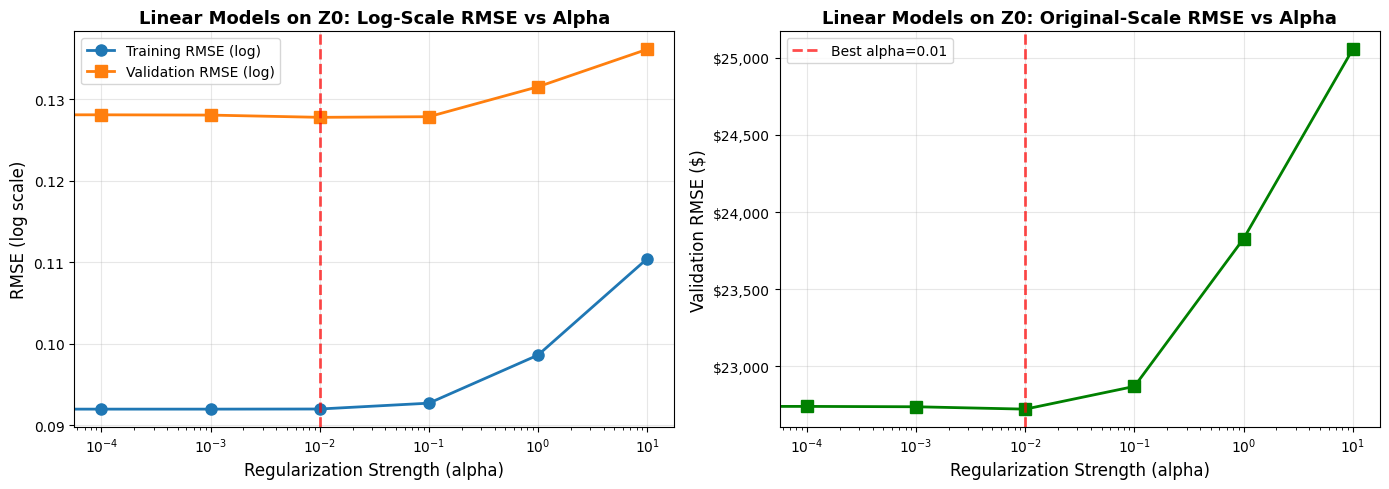


Visualization complete: Alpha vs RMSE for linear models on Z0


In [30]:
# ==============================================================================
# VISUALIZATION: ALPHA VS PERFORMANCE
# ==============================================================================
# Plot validation RMSE as a function of regularization strength (alpha)
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data for plotting
alphas = linear_z0_results['hyperparam_value'].values
train_rmse_log = linear_z0_results['train_rmse_log'].values
val_rmse_log = linear_z0_results['val_rmse_log'].values
val_rmse_orig = linear_z0_results['val_rmse_orig'].values

# Plot 1: Log-scale RMSE vs Alpha
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Training RMSE (log)', linewidth=2, markersize=8)
ax1.plot(alphas, val_rmse_log, 's-', label='Validation RMSE (log)', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax1.set_ylabel('RMSE (log scale)', fontsize=12)
ax1.set_title('Linear Models on Z0: Log-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axvline(best_model['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model['hyperparam_value']}")

# Plot 2: Original-scale RMSE vs Alpha
ax2 = axes[1]
ax2.plot(alphas, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
ax2.set_title('Linear Models on Z0: Original-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(best_model['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model['hyperparam_value']}")
ax2.legend(fontsize=10)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nVisualization complete: Alpha vs RMSE for linear models on Z0")

### Experiments: Linear Models in Z1

Run systematic experiments with OLS and Ridge regression on the log-transformed feature space (Z1).


In [31]:
# ==============================================================================
# EXPERIMENT: UNREGULARIZED LINEAR REGRESSION ON Z1
# ==============================================================================

print("="*70)
print("EXPERIMENT: OLS (Unregularized) on Z1")
print("="*70)

# Build pipeline using helper function
pipeline_ols = build_linear_pipeline('Z1', alpha=None, use_ridge=False)

# Fit on training data
print("\nFitting OLS model...")
pipeline_ols.fit(X_train, y_train)

# Make predictions
print("Generating predictions...")
y_train_pred = pipeline_ols.predict(X_train)
y_val_pred = pipeline_ols.predict(X_val)

# Evaluate using metrics helper
metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)

# Create result row
result_row = {
    'model_family': 'linear',
    'model_type': 'ols',
    'z_space': 'Z1',
    'hyperparam_name': 'alpha',
    'hyperparam_value': 0.0,
    **metrics
}

# Append to results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Display results
print("\nOLS Results:")
print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
print(f"\n  Training RMSE (original $): ${metrics['train_rmse_orig']:,.2f}")
print(f"  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
print(f"  Training R² (original): {metrics['train_r2_orig']:.6f}")
print(f"  Validation R² (original): {metrics['val_r2_orig']:.6f}")

print("\n" + "="*70)
print(f"OLS experiment on Z1 complete. Results stored in results_df.")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)


EXPERIMENT: OLS (Unregularized) on Z1
Selected preprocessor: Z1
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z1 → LinearRegression (OLS, no regularization)

Fitting OLS model...
Generating predictions...

OLS Results:
  Training RMSE (log): 0.089377
  Validation RMSE (log): 0.124314
  Training R² (log): 0.947598
  Validation R² (log): 0.917186

  Training RMSE (original $): $17,414.61
  Validation RMSE (original $): $22,956.20
  Training R² (original): 0.949155
  Validation R² (original): 0.931295

OLS experiment on Z1 complete. Results stored in results_df.
Current results_df shape: (8, 17)


In [32]:
# ==============================================================================
# EXPERIMENTS: RIDGE REGRESSION WITH VARYING ALPHA ON Z1
# ==============================================================================

print("="*70)
print("EXPERIMENTS: Ridge Regression on Z1")
print("="*70)
print(f"Alpha grid: {ALPHA_GRID}")
print(f"Number of experiments: {len(ALPHA_GRID)}")
print("="*70)

# Loop over all alpha values
for i, alpha in enumerate(ALPHA_GRID, start=1):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}: Ridge with alpha={alpha} on Z1")
    print(f"{'='*70}")
    
    # Build pipeline using helper function
    pipeline_ridge = build_linear_pipeline('Z1', alpha=alpha, use_ridge=True)
    
    # Fit on training data
    print(f"\nFitting Ridge model (alpha={alpha})...")
    pipeline_ridge.fit(X_train, y_train)
    
    # Make predictions
    print("Generating predictions...")
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate using metrics helper
    metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
    
    # Create result row
    result_row = {
        'model_family': 'linear',
        'model_type': 'ridge',
        'z_space': 'Z1',
        'hyperparam_name': 'alpha',
        'hyperparam_value': alpha,
        **metrics
    }
    
    # Append to results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
    
    # Display results
    print(f"\nRidge (alpha={alpha}) Results:")
    print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
    print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
    print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
    print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
    print(f"\n  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
    
    print(f"\nExperiment {i} complete. Current results_df shape: {results_df.shape}")

print("\n" + "="*70)
print("ALL RIDGE EXPERIMENTS ON Z1 COMPLETE")
print("="*70)
print(f"Results DataFrame now contains {len(results_df)} experiments")
print("="*70)


EXPERIMENTS: Ridge Regression on Z1
Alpha grid: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Number of experiments: 6

EXPERIMENT 1: Ridge with alpha=0.0001 on Z1
Selected preprocessor: Z1
Selected model: Ridge(alpha=0.0001)
Pipeline created: Z1 → Ridge(alpha=0.0001)

Fitting Ridge model (alpha=0.0001)...
Generating predictions...

Ridge (alpha=0.0001) Results:
  Training RMSE (log): 0.089377
  Validation RMSE (log): 0.124315
  Training R² (log): 0.947598
  Validation R² (log): 0.917184

  Validation RMSE (original $): $22,956.50

Experiment 1 complete. Current results_df shape: (9, 17)

EXPERIMENT 2: Ridge with alpha=0.001 on Z1
Selected preprocessor: Z1
Selected model: Ridge(alpha=0.001)
Pipeline created: Z1 → Ridge(alpha=0.001)

Fitting Ridge model (alpha=0.001)...
Generating predictions...

Ridge (alpha=0.001) Results:
  Training RMSE (log): 0.089377
  Validation RMSE (log): 0.124326
  Training R² (log): 0.947598
  Validation R² (log): 0.917170

  Validation RMSE (original $): $22,959.16


In [33]:
# ==============================================================================
# SUMMARY: LINEAR MODELS ON Z1
# ==============================================================================

print("="*70)
print("LINEAR MODELS ON Z1 - SUMMARY")
print("="*70)

# Filter results for linear models on Z1
linear_z1_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z1')
].copy()

# Sort by validation RMSE (log)
linear_z1_results_sorted = linear_z1_results.sort_values('val_rmse_log')

print(f"\nAll Linear Models on Z1 (sorted by {MODEL_SELECTION_METRIC}):")
print("-"*70)

# Display key metrics for all models
display_cols = ['model_type', 'hyperparam_value', 'val_rmse_log', 'val_r2_log', 
                'val_rmse_orig', 'train_rmse_log']
print(linear_z1_results_sorted[display_cols].to_string(index=False))

# Identify best model
best_model_z1 = linear_z1_results_sorted.iloc[0]
print("\n" + "="*70)
print("BEST LINEAR MODEL ON Z1:")
print("="*70)
print(f"  Model type: {best_model_z1['model_type']}")
print(f"  Hyperparameter: {best_model_z1['hyperparam_name']} = {best_model_z1['hyperparam_value']}")
print(f"\n  Performance:")
print(f"    Validation RMSE (log): {best_model_z1['val_rmse_log']:.6f}")
print(f"    Validation R² (log): {best_model_z1['val_r2_log']:.6f}")
print(f"    Validation RMSE (original $): ${best_model_z1['val_rmse_orig']:,.2f}")
print(f"\n  Training metrics:")
print(f"    Training RMSE (log): {best_model_z1['train_rmse_log']:.6f}")
print(f"    Training R² (log): {best_model_z1['train_r2_log']:.6f}")

# Calculate overfitting indicator
overfit_gap = best_model_z1['val_rmse_log'] - best_model_z1['train_rmse_log']
print(f"\n  Overfitting analysis:")
print(f"    RMSE gap (val - train): {overfit_gap:.6f}")
if overfit_gap < 0.01:
    print(f"    Status: Minimal overfitting ✓")
elif overfit_gap < 0.05:
    print(f"    Status: Slight overfitting")
else:
    print(f"    Status: Moderate overfitting")

print("="*70)


LINEAR MODELS ON Z1 - SUMMARY

All Linear Models on Z1 (sorted by val_rmse_log):
----------------------------------------------------------------------
model_type  hyperparam_value  val_rmse_log  val_r2_log  val_rmse_orig  train_rmse_log
       ols            0.0000      0.124314    0.917186   22956.204425        0.089377
     ridge            0.0001      0.124315    0.917184   22956.499314        0.089377
     ridge            0.0010      0.124326    0.917170   22959.161666        0.089377
     ridge            0.0100      0.124437    0.917023   22986.459522        0.089382
     ridge            0.1000      0.125652    0.915393   23255.335013        0.089641
     ridge            1.0000      0.128674    0.911275   24250.426345        0.092958
     ridge           10.0000      0.131541    0.907278   25711.804015        0.102710

BEST LINEAR MODEL ON Z1:
  Model type: ols
  Hyperparameter: alpha = 0.0

  Performance:
    Validation RMSE (log): 0.124314
    Validation R² (log): 0.917186


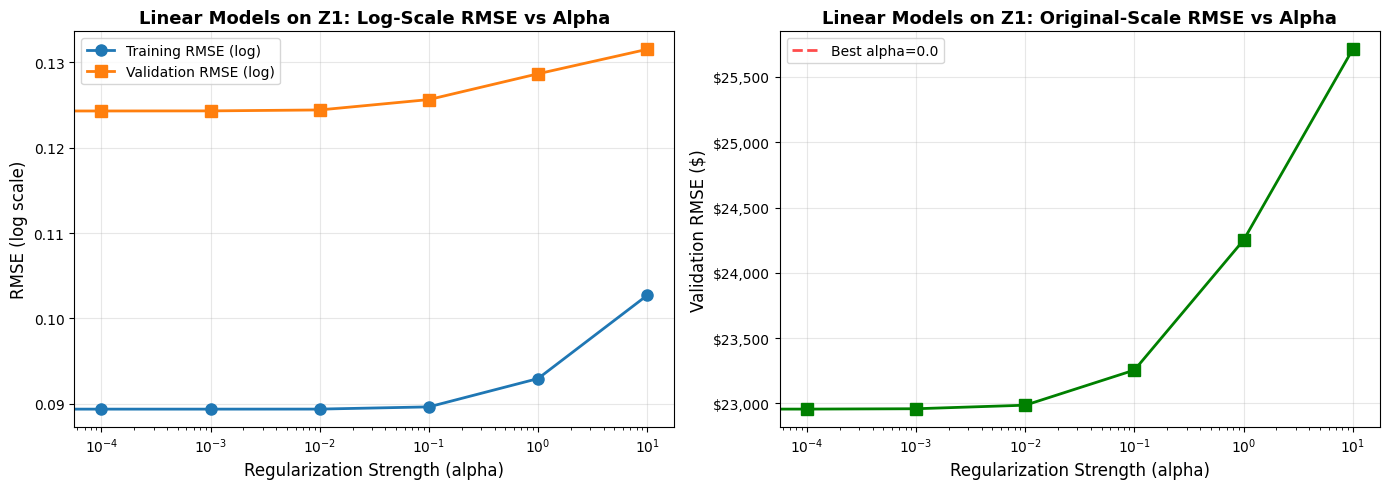


Visualization complete: Alpha vs RMSE for linear models on Z1


In [34]:
# ==============================================================================
# VISUALIZATION: ALPHA VS PERFORMANCE FOR Z1
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data for plotting
alphas = linear_z1_results['hyperparam_value'].values
train_rmse_log = linear_z1_results['train_rmse_log'].values
val_rmse_log = linear_z1_results['val_rmse_log'].values
val_rmse_orig = linear_z1_results['val_rmse_orig'].values

# Plot 1: Log-scale RMSE vs Alpha
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Training RMSE (log)', linewidth=2, markersize=8)
ax1.plot(alphas, val_rmse_log, 's-', label='Validation RMSE (log)', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax1.set_ylabel('RMSE (log scale)', fontsize=12)
ax1.set_title('Linear Models on Z1: Log-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axvline(best_model_z1['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z1['hyperparam_value']}")

# Plot 2: Original-scale RMSE vs Alpha
ax2 = axes[1]
ax2.plot(alphas, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
ax2.set_title('Linear Models on Z1: Original-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(best_model_z1['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z1['hyperparam_value']}")
ax2.legend(fontsize=10)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nVisualization complete: Alpha vs RMSE for linear models on Z1")


### Experiments: Linear Models in Z2

Run systematic experiments with OLS and Ridge regression on the polynomial feature space (Z2).


In [35]:
# ==============================================================================
# EXPERIMENT: UNREGULARIZED LINEAR REGRESSION ON Z2
# ==============================================================================

print("="*70)
print("EXPERIMENT: OLS (Unregularized) on Z2")
print("="*70)

# Build pipeline using helper function
pipeline_ols = build_linear_pipeline('Z2', alpha=None, use_ridge=False)

# Fit on training data
print("\nFitting OLS model...")
pipeline_ols.fit(X_train, y_train)

# Make predictions
print("Generating predictions...")
y_train_pred = pipeline_ols.predict(X_train)
y_val_pred = pipeline_ols.predict(X_val)

# Evaluate using metrics helper
metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)

# Create result row
result_row = {
    'model_family': 'linear',
    'model_type': 'ols',
    'z_space': 'Z2',
    'hyperparam_name': 'alpha',
    'hyperparam_value': 0.0,
    **metrics
}

# Append to results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Display results
print("\nOLS Results:")
print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
print(f"\n  Training RMSE (original $): ${metrics['train_rmse_orig']:,.2f}")
print(f"  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
print(f"  Training R² (original): {metrics['train_r2_orig']:.6f}")
print(f"  Validation R² (original): {metrics['val_r2_orig']:.6f}")

print("\n" + "="*70)
print(f"OLS experiment on Z2 complete. Results stored in results_df.")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)


EXPERIMENT: OLS (Unregularized) on Z2
Selected preprocessor: Z2
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z2 → LinearRegression (OLS, no regularization)

Fitting OLS model...
Generating predictions...

OLS Results:
  Training RMSE (log): 0.087478
  Validation RMSE (log): 0.129261
  Training R² (log): 0.949802
  Validation R² (log): 0.910464

  Training RMSE (original $): $16,640.44
  Validation RMSE (original $): $27,310.09
  Training R² (original): 0.953575
  Validation R² (original): 0.902763

OLS experiment on Z2 complete. Results stored in results_df.
Current results_df shape: (15, 17)


In [36]:
# ==============================================================================
# EXPERIMENTS: RIDGE REGRESSION WITH VARYING ALPHA ON Z2
# ==============================================================================

print("="*70)
print("EXPERIMENTS: Ridge Regression on Z2")
print("="*70)
print(f"Alpha grid: {ALPHA_GRID}")
print(f"Number of experiments: {len(ALPHA_GRID)}")
print("="*70)

# Loop over all alpha values
for i, alpha in enumerate(ALPHA_GRID, start=1):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}: Ridge with alpha={alpha} on Z2")
    print(f"{'='*70}")
    
    # Build pipeline using helper function
    pipeline_ridge = build_linear_pipeline('Z2', alpha=alpha, use_ridge=True)
    
    # Fit on training data
    print(f"\nFitting Ridge model (alpha={alpha})...")
    pipeline_ridge.fit(X_train, y_train)
    
    # Make predictions
    print("Generating predictions...")
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate using metrics helper
    metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
    
    # Create result row
    result_row = {
        'model_family': 'linear',
        'model_type': 'ridge',
        'z_space': 'Z2',
        'hyperparam_name': 'alpha',
        'hyperparam_value': alpha,
        **metrics
    }
    
    # Append to results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
    
    # Display results
    print(f"\nRidge (alpha={alpha}) Results:")
    print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
    print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
    print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
    print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
    print(f"\n  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
    
    print(f"\nExperiment {i} complete. Current results_df shape: {results_df.shape}")

print("\n" + "="*70)
print("ALL RIDGE EXPERIMENTS ON Z2 COMPLETE")
print("="*70)
print(f"Results DataFrame now contains {len(results_df)} experiments")
print("="*70)


EXPERIMENTS: Ridge Regression on Z2
Alpha grid: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Number of experiments: 6

EXPERIMENT 1: Ridge with alpha=0.0001 on Z2
Selected preprocessor: Z2
Selected model: Ridge(alpha=0.0001)
Pipeline created: Z2 → Ridge(alpha=0.0001)

Fitting Ridge model (alpha=0.0001)...
Generating predictions...

Ridge (alpha=0.0001) Results:
  Training RMSE (log): 0.087478
  Validation RMSE (log): 0.129244
  Training R² (log): 0.949802
  Validation R² (log): 0.910488

  Validation RMSE (original $): $27,304.17

Experiment 1 complete. Current results_df shape: (16, 17)

EXPERIMENT 2: Ridge with alpha=0.001 on Z2
Selected preprocessor: Z2
Selected model: Ridge(alpha=0.001)
Pipeline created: Z2 → Ridge(alpha=0.001)

Fitting Ridge model (alpha=0.001)...
Generating predictions...

Ridge (alpha=0.001) Results:
  Training RMSE (log): 0.087478
  Validation RMSE (log): 0.129094
  Training R² (log): 0.949801
  Validation R² (log): 0.910695

  Validation RMSE (original $): $27,252.50

In [37]:
# ==============================================================================
# SUMMARY: LINEAR MODELS ON Z2
# ==============================================================================

print("="*70)
print("LINEAR MODELS ON Z2 - SUMMARY")
print("="*70)

# Filter results for linear models on Z2
linear_z2_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z2')
].copy()

# Sort by validation RMSE (log)
linear_z2_results_sorted = linear_z2_results.sort_values('val_rmse_log')

print(f"\nAll Linear Models on Z2 (sorted by {MODEL_SELECTION_METRIC}):")
print("-"*70)

# Display key metrics for all models
display_cols = ['model_type', 'hyperparam_value', 'val_rmse_log', 'val_r2_log', 
                'val_rmse_orig', 'train_rmse_log']
print(linear_z2_results_sorted[display_cols].to_string(index=False))

# Identify best model
best_model_z2 = linear_z2_results_sorted.iloc[0]
print("\n" + "="*70)
print("BEST LINEAR MODEL ON Z2:")
print("="*70)
print(f"  Model type: {best_model_z2['model_type']}")
print(f"  Hyperparameter: {best_model_z2['hyperparam_name']} = {best_model_z2['hyperparam_value']}")
print(f"\n  Performance:")
print(f"    Validation RMSE (log): {best_model_z2['val_rmse_log']:.6f}")
print(f"    Validation R² (log): {best_model_z2['val_r2_log']:.6f}")
print(f"    Validation RMSE (original $): ${best_model_z2['val_rmse_orig']:,.2f}")
print(f"\n  Training metrics:")
print(f"    Training RMSE (log): {best_model_z2['train_rmse_log']:.6f}")
print(f"    Training R² (log): {best_model_z2['train_r2_log']:.6f}")

# Calculate overfitting indicator
overfit_gap = best_model_z2['val_rmse_log'] - best_model_z2['train_rmse_log']
print(f"\n  Overfitting analysis:")
print(f"    RMSE gap (val - train): {overfit_gap:.6f}")
if overfit_gap < 0.01:
    print(f"    Status: Minimal overfitting ✓")
elif overfit_gap < 0.05:
    print(f"    Status: Slight overfitting")
else:
    print(f"    Status: Moderate overfitting")

print("="*70)


LINEAR MODELS ON Z2 - SUMMARY

All Linear Models on Z2 (sorted by val_rmse_log):
----------------------------------------------------------------------
model_type  hyperparam_value  val_rmse_log  val_r2_log  val_rmse_orig  train_rmse_log
     ridge            1.0000      0.124788    0.916554   25804.150395        0.089243
     ridge            0.1000      0.124809    0.916526   25863.942818        0.087770
     ridge            0.0100      0.127926    0.912304   26860.147545        0.087493
     ridge            0.0010      0.129094    0.910695   27252.499298        0.087478
     ridge            0.0001      0.129244    0.910488   27304.168596        0.087478
       ols            0.0000      0.129261    0.910464   27310.093838        0.087478
     ridge           10.0000      0.130442    0.908821   27086.800494        0.094456

BEST LINEAR MODEL ON Z2:
  Model type: ridge
  Hyperparameter: alpha = 1.0

  Performance:
    Validation RMSE (log): 0.124788
    Validation R² (log): 0.91655

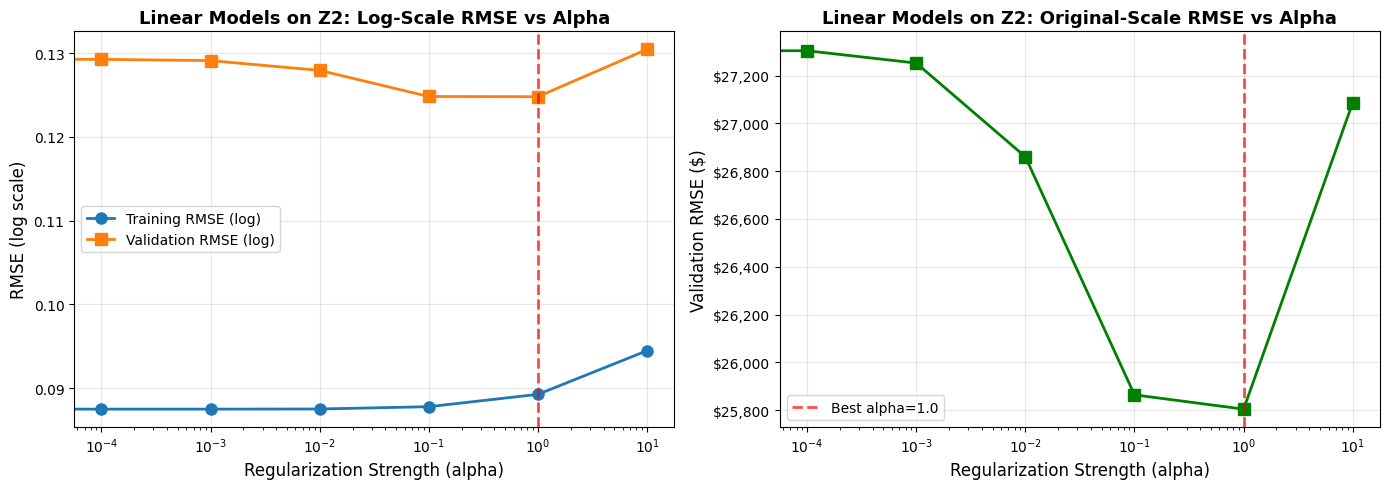


Visualization complete: Alpha vs RMSE for linear models on Z2


In [38]:
# ==============================================================================
# VISUALIZATION: ALPHA VS PERFORMANCE FOR Z2
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data for plotting
alphas = linear_z2_results['hyperparam_value'].values
train_rmse_log = linear_z2_results['train_rmse_log'].values
val_rmse_log = linear_z2_results['val_rmse_log'].values
val_rmse_orig = linear_z2_results['val_rmse_orig'].values

# Plot 1: Log-scale RMSE vs Alpha
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Training RMSE (log)', linewidth=2, markersize=8)
ax1.plot(alphas, val_rmse_log, 's-', label='Validation RMSE (log)', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax1.set_ylabel('RMSE (log scale)', fontsize=12)
ax1.set_title('Linear Models on Z2: Log-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axvline(best_model_z2['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z2['hyperparam_value']}")

# Plot 2: Original-scale RMSE vs Alpha
ax2 = axes[1]
ax2.plot(alphas, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
ax2.set_title('Linear Models on Z2: Original-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(best_model_z2['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z2['hyperparam_value']}")
ax2.legend(fontsize=10)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nVisualization complete: Alpha vs RMSE for linear models on Z2")


### Experiments: Linear Models in Z3

Run systematic experiments with OLS and Ridge regression on the PCA-compressed feature space (Z3).


In [39]:
# ==============================================================================
# EXPERIMENT: UNREGULARIZED LINEAR REGRESSION ON Z3
# ==============================================================================

print("="*70)
print("EXPERIMENT: OLS (Unregularized) on Z3")
print("="*70)

# Build pipeline using helper function
pipeline_ols = build_linear_pipeline('Z3', alpha=None, use_ridge=False)

# Fit on training data
print("\nFitting OLS model...")
pipeline_ols.fit(X_train, y_train)

# Make predictions
print("Generating predictions...")
y_train_pred = pipeline_ols.predict(X_train)
y_val_pred = pipeline_ols.predict(X_val)

# Evaluate using metrics helper
metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)

# Create result row
result_row = {
    'model_family': 'linear',
    'model_type': 'ols',
    'z_space': 'Z3',
    'hyperparam_name': 'alpha',
    'hyperparam_value': 0.0,
    **metrics
}

# Append to results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Display results
print("\nOLS Results:")
print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
print(f"\n  Training RMSE (original $): ${metrics['train_rmse_orig']:,.2f}")
print(f"  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
print(f"  Training R² (original): {metrics['train_r2_orig']:.6f}")
print(f"  Validation R² (original): {metrics['val_r2_orig']:.6f}")

print("\n" + "="*70)
print(f"OLS experiment on Z3 complete. Results stored in results_df.")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)


EXPERIMENT: OLS (Unregularized) on Z3
Selected preprocessor: Z3
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z3 → LinearRegression (OLS, no regularization)

Fitting OLS model...
Generating predictions...

OLS Results:
  Training RMSE (log): 0.097276
  Validation RMSE (log): 0.130030
  Training R² (log): 0.937927
  Validation R² (log): 0.909395

  Training RMSE (original $): $18,241.12
  Validation RMSE (original $): $23,644.38
  Training R² (original): 0.944214
  Validation R² (original): 0.927114

OLS experiment on Z3 complete. Results stored in results_df.
Current results_df shape: (22, 17)


In [40]:
# ==============================================================================
# EXPERIMENTS: RIDGE REGRESSION WITH VARYING ALPHA ON Z3
# ==============================================================================

print("="*70)
print("EXPERIMENTS: Ridge Regression on Z3")
print("="*70)
print(f"Alpha grid: {ALPHA_GRID}")
print(f"Number of experiments: {len(ALPHA_GRID)}")
print("="*70)

# Loop over all alpha values
for i, alpha in enumerate(ALPHA_GRID, start=1):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}: Ridge with alpha={alpha} on Z3")
    print(f"{'='*70}")
    
    # Build pipeline using helper function
    pipeline_ridge = build_linear_pipeline('Z3', alpha=alpha, use_ridge=True)
    
    # Fit on training data
    print(f"\nFitting Ridge model (alpha={alpha})...")
    pipeline_ridge.fit(X_train, y_train)
    
    # Make predictions
    print("Generating predictions...")
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate using metrics helper
    metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
    
    # Create result row
    result_row = {
        'model_family': 'linear',
        'model_type': 'ridge',
        'z_space': 'Z3',
        'hyperparam_name': 'alpha',
        'hyperparam_value': alpha,
        **metrics
    }
    
    # Append to results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
    
    # Display results
    print(f"\nRidge (alpha={alpha}) Results:")
    print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
    print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
    print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
    print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
    print(f"\n  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
    
    print(f"\nExperiment {i} complete. Current results_df shape: {results_df.shape}")

print("\n" + "="*70)
print("ALL RIDGE EXPERIMENTS ON Z3 COMPLETE")
print("="*70)
print(f"Results DataFrame now contains {len(results_df)} experiments")
print("="*70)


EXPERIMENTS: Ridge Regression on Z3
Alpha grid: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Number of experiments: 6

EXPERIMENT 1: Ridge with alpha=0.0001 on Z3
Selected preprocessor: Z3
Selected model: Ridge(alpha=0.0001)
Pipeline created: Z3 → Ridge(alpha=0.0001)

Fitting Ridge model (alpha=0.0001)...
Generating predictions...

Ridge (alpha=0.0001) Results:
  Training RMSE (log): 0.097276
  Validation RMSE (log): 0.130031
  Training R² (log): 0.937927
  Validation R² (log): 0.909394

  Validation RMSE (original $): $23,644.55

Experiment 1 complete. Current results_df shape: (23, 17)

EXPERIMENT 2: Ridge with alpha=0.001 on Z3
Selected preprocessor: Z3
Selected model: Ridge(alpha=0.001)
Pipeline created: Z3 → Ridge(alpha=0.001)

Fitting Ridge model (alpha=0.001)...
Generating predictions...

Ridge (alpha=0.001) Results:
  Training RMSE (log): 0.097276
  Validation RMSE (log): 0.130036
  Training R² (log): 0.937926
  Validation R² (log): 0.909388

  Validation RMSE (original $): $23,646.11

In [41]:
# ==============================================================================
# SUMMARY: LINEAR MODELS ON Z3
# ==============================================================================

print("="*70)
print("LINEAR MODELS ON Z3 - SUMMARY")
print("="*70)

# Filter results for linear models on Z3
linear_z3_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z3')
].copy()

# Sort by validation RMSE (log)
linear_z3_results_sorted = linear_z3_results.sort_values('val_rmse_log')

print(f"\nAll Linear Models on Z3 (sorted by {MODEL_SELECTION_METRIC}):")
print("-"*70)

# Display key metrics for all models
display_cols = ['model_type', 'hyperparam_value', 'val_rmse_log', 'val_r2_log', 
                'val_rmse_orig', 'train_rmse_log']
print(linear_z3_results_sorted[display_cols].to_string(index=False))

# Identify best model
best_model_z3 = linear_z3_results_sorted.iloc[0]
print("\n" + "="*70)
print("BEST LINEAR MODEL ON Z3:")
print("="*70)
print(f"  Model type: {best_model_z3['model_type']}")
print(f"  Hyperparameter: {best_model_z3['hyperparam_name']} = {best_model_z3['hyperparam_value']}")
print(f"\n  Performance:")
print(f"    Validation RMSE (log): {best_model_z3['val_rmse_log']:.6f}")
print(f"    Validation R² (log): {best_model_z3['val_r2_log']:.6f}")
print(f"    Validation RMSE (original $): ${best_model_z3['val_rmse_orig']:,.2f}")
print(f"\n  Training metrics:")
print(f"    Training RMSE (log): {best_model_z3['train_rmse_log']:.6f}")
print(f"    Training R² (log): {best_model_z3['train_r2_log']:.6f}")

# Calculate overfitting indicator
overfit_gap = best_model_z3['val_rmse_log'] - best_model_z3['train_rmse_log']
print(f"\n  Overfitting analysis:")
print(f"    RMSE gap (val - train): {overfit_gap:.6f}")
if overfit_gap < 0.01:
    print(f"    Status: Minimal overfitting ✓")
elif overfit_gap < 0.05:
    print(f"    Status: Slight overfitting")
else:
    print(f"    Status: Moderate overfitting")

print("="*70)


LINEAR MODELS ON Z3 - SUMMARY

All Linear Models on Z3 (sorted by val_rmse_log):
----------------------------------------------------------------------
model_type  hyperparam_value  val_rmse_log  val_r2_log  val_rmse_orig  train_rmse_log
       ols            0.0000      0.130030    0.909395   23644.375560        0.097276
     ridge            0.0001      0.130031    0.909394   23644.546671        0.097276
     ridge            0.0010      0.130036    0.909388   23646.106467        0.097276
     ridge            0.0100      0.130102    0.909295   23663.403475        0.097284
     ridge            0.1000      0.131527    0.907297   23878.339318        0.097719
     ridge            1.0000      0.135726    0.901283   24495.383513        0.102806
     ridge           10.0000      0.138555    0.897125   24919.623214        0.116512

BEST LINEAR MODEL ON Z3:
  Model type: ols
  Hyperparameter: alpha = 0.0

  Performance:
    Validation RMSE (log): 0.130030
    Validation R² (log): 0.909395


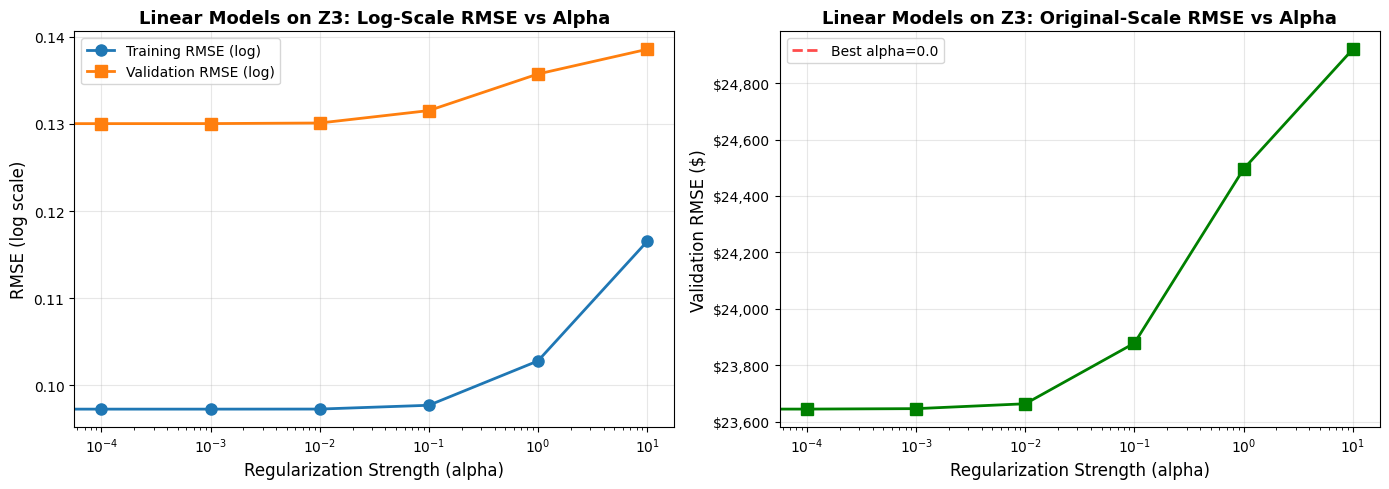


Visualization complete: Alpha vs RMSE for linear models on Z3


In [42]:
# ==============================================================================
# VISUALIZATION: ALPHA VS PERFORMANCE FOR Z3
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data for plotting
alphas = linear_z3_results['hyperparam_value'].values
train_rmse_log = linear_z3_results['train_rmse_log'].values
val_rmse_log = linear_z3_results['val_rmse_log'].values
val_rmse_orig = linear_z3_results['val_rmse_orig'].values

# Plot 1: Log-scale RMSE vs Alpha
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Training RMSE (log)', linewidth=2, markersize=8)
ax1.plot(alphas, val_rmse_log, 's-', label='Validation RMSE (log)', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax1.set_ylabel('RMSE (log scale)', fontsize=12)
ax1.set_title('Linear Models on Z3: Log-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axvline(best_model_z3['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z3['hyperparam_value']}")

# Plot 2: Original-scale RMSE vs Alpha
ax2 = axes[1]
ax2.plot(alphas, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
ax2.set_title('Linear Models on Z3: Original-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(best_model_z3['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model_z3['hyperparam_value']}")
ax2.legend(fontsize=10)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nVisualization complete: Alpha vs RMSE for linear models on Z3")


## K-Nearest Neighbors Regression

- Uses Z0–Z3 feature spaces (same preprocessing).
- Hyperparameter: n_neighbors (K).
- Distance-based, so scaling of numeric features is critical (already handled by your pipelines).


In [43]:
# ==============================================================================
# KNN HYPERPARAMETER CONFIGURATION
# ==============================================================================

# K values to test (number of neighbors)
K_VALUES = [1, 3, 5, 7, 9, 15]  # 6 values (satisfies ≥6 hyperparams requirement)

# Weighting scheme for neighbors
KNN_WEIGHTS = "uniform"  # All neighbors weighted equally
# Alternative: "distance" weights closer neighbors more heavily

print(f"KNN Hyperparameter Configuration:")
print(f"  K values to test: {K_VALUES}")
print(f"  Total configurations: {len(K_VALUES)}")
print(f"  Weights: {KNN_WEIGHTS}")

print(f"\nBias-Variance Tradeoff:")
print(f"  Small K (e.g., K=1, K=3):")
print(f"    → Low bias / High variance")
print(f"    → More flexible, captures local patterns")
print(f"    → Risk: Overfitting to training noise")
print(f"\n  Large K (e.g., K=9, K=15):")
print(f"    → Higher bias / Lower variance") 
print(f"    → More smoothing, averages over larger regions")
print(f"    → Risk: Underfitting, missing local details")


KNN Hyperparameter Configuration:
  K values to test: [1, 3, 5, 7, 9, 15]
  Total configurations: 6
  Weights: uniform

Bias-Variance Tradeoff:
  Small K (e.g., K=1, K=3):
    → Low bias / High variance
    → More flexible, captures local patterns
    → Risk: Overfitting to training noise

  Large K (e.g., K=9, K=15):
    → Higher bias / Lower variance
    → More smoothing, averages over larger regions
    → Risk: Underfitting, missing local details


### Helper to build KNN pipelines


In [44]:
from sklearn.neighbors import KNeighborsRegressor

def build_knn_pipeline(z_name, n_neighbors, weights='uniform'):
    """
    Build a scikit-learn Pipeline for KNN regression models across feature spaces.
    
    Parameters:
    -----------
    z_name : str
        Feature space identifier ('Z0', 'Z1', 'Z2', or 'Z3')
    n_neighbors : int
        Number of neighbors (K) to use for predictions
    weights : str, default='uniform'
        Weight function for neighbors:
        - 'uniform': All neighbors weighted equally
        - 'distance': Weight points by inverse of their distance
    
    Returns:
    --------
    Pipeline : sklearn.pipeline.Pipeline
        Complete pipeline with preprocessing and KNN model.
        Structure: [('preprocess', preprocessor), ('model', knn_model)]
    
    Raises:
    -------
    ValueError
        If z_name is not in PREPROCESSORS registry ('Z0', 'Z1', 'Z2', 'Z3')
    
    Feature Space Mapping:
    ----------------------
    Z0: Baseline (standard preprocessing)
    Z1: Log-transformed skewed features + standard preprocessing
    Z2: Polynomial features (degree 2) + standard preprocessing
    Z3: PCA-compressed numerics + one-hot categoricals
    
    Important Note:
    ---------------
    KNN is sensitive to scale; numeric scaling in all Z-spaces is required 
    and already handled by the preprocessors. Without proper scaling, features 
    with larger magnitudes would dominate the distance calculations.
    
    Examples:
    ---------
    >>> # KNN with K=5 on baseline features
    >>> pipeline = build_knn_pipeline('Z0', n_neighbors=5)
    
    >>> # KNN with K=3 on log-transformed features
    >>> pipeline = build_knn_pipeline('Z1', n_neighbors=3)
    
    >>> # KNN with K=9 and distance weighting on PCA features
    >>> pipeline = build_knn_pipeline('Z3', n_neighbors=9, weights='distance')
    """
    
    # ==========================================================================
    # STEP 1: SELECT PREPROCESSOR FROM CENTRALIZED REGISTRY
    # ==========================================================================
    
    # Validate feature space name
    if z_name not in PREPROCESSORS:
        valid_spaces = list(PREPROCESSORS.keys())
        raise ValueError(
            f"Unknown feature space: '{z_name}'. "
            f"Must be one of {valid_spaces}."
        )
    
    # Lookup preprocessor from registry
    preprocessor = PREPROCESSORS[z_name]
    print(f"Selected preprocessor: {z_name}")
    
    # ==========================================================================
    # STEP 2: CREATE KNN REGRESSOR MODEL
    # ==========================================================================
    
    # Create KNeighborsRegressor with specified parameters
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights
    )
    model_desc = f"KNeighborsRegressor(n_neighbors={n_neighbors}, weights='{weights}')"
    
    print(f"Selected model: {model_desc}")
    
    # ==========================================================================
    # STEP 3: CONSTRUCT PIPELINE
    # ==========================================================================
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    print(f"Pipeline created: {z_name} → KNN(K={n_neighbors})")
    
    return pipeline


print("KNN pipeline builder function created: build_knn_pipeline()")
print("\nUsage:")
print("  pipeline = build_knn_pipeline(z_name='Z0', n_neighbors=5)")
print("\nNote: KNN is distance-based and requires feature scaling.")
print("      All preprocessors already include StandardScaler for numeric features.")


KNN pipeline builder function created: build_knn_pipeline()

Usage:
  pipeline = build_knn_pipeline(z_name='Z0', n_neighbors=5)

Note: KNN is distance-based and requires feature scaling.
      All preprocessors already include StandardScaler for numeric features.


### Experiments: KNN across Z-spaces

Run systematic experiments with KNN regression across all feature spaces (Z0, Z1, Z2, Z3) and all K values.


In [45]:
# ==============================================================================
# KNN EXPERIMENTS: ALL Z-SPACES × ALL K VALUES
# ==============================================================================
# Systematic grid search across feature spaces and number of neighbors
# Structure: Outer loop over Z-spaces, inner loop over K values
# ==============================================================================

# Define feature spaces to test
Z_SPACES = ['Z0', 'Z1', 'Z2', 'Z3']

print("="*70)
print("KNN EXPERIMENTS: SYSTEMATIC GRID SEARCH")
print("="*70)
print(f"Feature spaces: {Z_SPACES}")
print(f"K values: {K_VALUES}")
print(f"Total experiments: {len(Z_SPACES)} × {len(K_VALUES)} = {len(Z_SPACES) * len(K_VALUES)}")
print(f"Weights: {KNN_WEIGHTS}")
print("="*70)

# Track experiment counter
experiment_counter = 0

# Outer loop: iterate through feature spaces
for z_space in Z_SPACES:
    print(f"\n{'='*70}")
    print(f"FEATURE SPACE: {z_space}")
    print(f"{'='*70}")
    
    # Inner loop: iterate through K values
    for k in K_VALUES:
        experiment_counter += 1
        
        print(f"\n[Experiment {experiment_counter}/{len(Z_SPACES) * len(K_VALUES)}] "
              f"Z-space: {z_space}, K: {k}")
        print("-" * 50)
        
        # Build pipeline using helper function
        pipeline = build_knn_pipeline(z_space, n_neighbors=k, weights=KNN_WEIGHTS)
        
        # Fit on training data
        print("Fitting model...")
        pipeline.fit(X_train, y_train)
        
        # Make predictions (in log space)
        print("Generating predictions...")
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)
        
        # Evaluate using metrics helper
        metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
        
        # Create result row
        result_row = {
            'model_family': 'knn',
            'model_type': 'knn_regressor',
            'z_space': z_space,
            'hyperparam_name': 'n_neighbors',
            'hyperparam_value': k,
            **metrics  # Unpack all metric values
        }
        
        # Append to results DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
        
        # Display brief results
        print(f"Results:")
        print(f"  Train RMSE (log): {metrics['train_rmse_log']:.6f}")
        print(f"  Val RMSE (log):   {metrics['val_rmse_log']:.6f}")
        print(f"  Val RMSE ($):     ${metrics['val_rmse_orig']:,.2f}")
        print(f"  Val R² (log):     {metrics['val_r2_log']:.6f}")

print(f"\n{'='*70}")
print(f"KNN EXPERIMENTS COMPLETE")
print(f"{'='*70}")
print(f"Total experiments run: {experiment_counter}")
print(f"Results appended to results_df")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)


KNN EXPERIMENTS: SYSTEMATIC GRID SEARCH
Feature spaces: ['Z0', 'Z1', 'Z2', 'Z3']
K values: [1, 3, 5, 7, 9, 15]
Total experiments: 4 × 6 = 24
Weights: uniform

FEATURE SPACE: Z0

[Experiment 1/24] Z-space: Z0, K: 1
--------------------------------------------------
Selected preprocessor: Z0
Selected model: KNeighborsRegressor(n_neighbors=1, weights='uniform')
Pipeline created: Z0 → KNN(K=1)
Fitting model...
Generating predictions...
Results:
  Train RMSE (log): 0.000000
  Val RMSE (log):   0.192930
  Val RMSE ($):     $37,113.04
  Val R² (log):     0.800537

[Experiment 2/24] Z-space: Z0, K: 3
--------------------------------------------------
Selected preprocessor: Z0
Selected model: KNeighborsRegressor(n_neighbors=3, weights='uniform')
Pipeline created: Z0 → KNN(K=3)
Fitting model...
Generating predictions...
Results:
  Train RMSE (log): 0.118957
  Val RMSE (log):   0.183730
  Val RMSE ($):     $37,915.18
  Val R² (log):     0.819107

[Experiment 3/24] Z-space: Z0, K: 5
--------------

In [46]:
# ==============================================================================
# DISPLAY KNN RESULTS
# ==============================================================================
# Extract and display all KNN experiments from results DataFrame
# ==============================================================================

# Filter results for KNN experiments
knn_results = results_df[results_df['model_family'] == 'knn'].copy()

print("="*70)
print("KNN EXPERIMENT RESULTS SUMMARY")
print("="*70)
print(f"Total KNN experiments: {len(knn_results)}")
print(f"Feature spaces tested: {sorted(knn_results['z_space'].unique())}")
print(f"K values tested: {sorted(knn_results['hyperparam_value'].unique())}")
print("="*70)

# Display full results table
print("\nKNN Results Table:")
print("-" * 70)

# Select key columns to display
display_columns = [
    'z_space', 
    'hyperparam_value',
    'train_rmse_log',
    'val_rmse_log',
    'val_rmse_orig',
    'train_r2_log',
    'val_r2_log'
]

# Format and display
knn_display = knn_results[display_columns].copy()
knn_display = knn_display.round({
    'train_rmse_log': 6,
    'val_rmse_log': 6,
    'val_rmse_orig': 2,
    'train_r2_log': 6,
    'val_r2_log': 6
})

# Rename columns for better display
knn_display.columns = [
    'Z-Space',
    'K',
    'Train RMSE (log)',
    'Val RMSE (log)',
    'Val RMSE ($)',
    'Train R²',
    'Val R²'
]

print(knn_display.to_string(index=False))

# Find best model per Z-space (by validation RMSE in log scale)
print("\n" + "="*70)
print("BEST KNN MODEL PER Z-SPACE (by Validation RMSE)")
print("="*70)

for z_space in sorted(knn_results['z_space'].unique()):
    z_results = knn_results[knn_results['z_space'] == z_space]
    best_idx = z_results['val_rmse_log'].idxmin()
    best = z_results.loc[best_idx]
    
    print(f"\n{z_space}:")
    print(f"  Best K: {int(best['hyperparam_value'])}")
    print(f"  Val RMSE (log): {best['val_rmse_log']:.6f}")
    print(f"  Val RMSE ($): ${best['val_rmse_orig']:,.2f}")
    print(f"  Val R²: {best['val_r2_log']:.6f}")

# Find overall best KNN model
best_overall_idx = knn_results['val_rmse_log'].idxmin()
best_overall = knn_results.loc[best_overall_idx]

print("\n" + "="*70)
print("OVERALL BEST KNN MODEL")
print("="*70)
print(f"Z-Space: {best_overall['z_space']}")
print(f"K: {int(best_overall['hyperparam_value'])}")
print(f"Val RMSE (log): {best_overall['val_rmse_log']:.6f}")
print(f"Val RMSE ($): ${best_overall['val_rmse_orig']:,.2f}")
print(f"Val R²: {best_overall['val_r2_log']:.6f}")
print("="*70)


KNN EXPERIMENT RESULTS SUMMARY
Total KNN experiments: 24
Feature spaces tested: ['Z0', 'Z1', 'Z2', 'Z3']
K values tested: [np.float64(1.0), np.float64(3.0), np.float64(5.0), np.float64(7.0), np.float64(9.0), np.float64(15.0)]

KNN Results Table:
----------------------------------------------------------------------
Z-Space    K  Train RMSE (log)  Val RMSE (log)  Val RMSE ($)  Train R²   Val R²
     Z0  1.0          0.000000        0.192930      37113.04  1.000000 0.800537
     Z0  3.0          0.118957        0.183730      37915.18  0.907172 0.819107
     Z0  5.0          0.136977        0.182835      38540.94  0.876920 0.820865
     Z0  7.0          0.146522        0.180356      38775.73  0.859169 0.825690
     Z0  9.0          0.149844        0.182784      39812.99  0.852711 0.820964
     Z0 15.0          0.159015        0.186403      41381.74  0.834130 0.813805
     Z1  1.0          0.000000        0.216031      44171.52  1.000000 0.749910
     Z1  3.0          0.126510        0.190

### Visualizations: KNN Performance Across Z-spaces


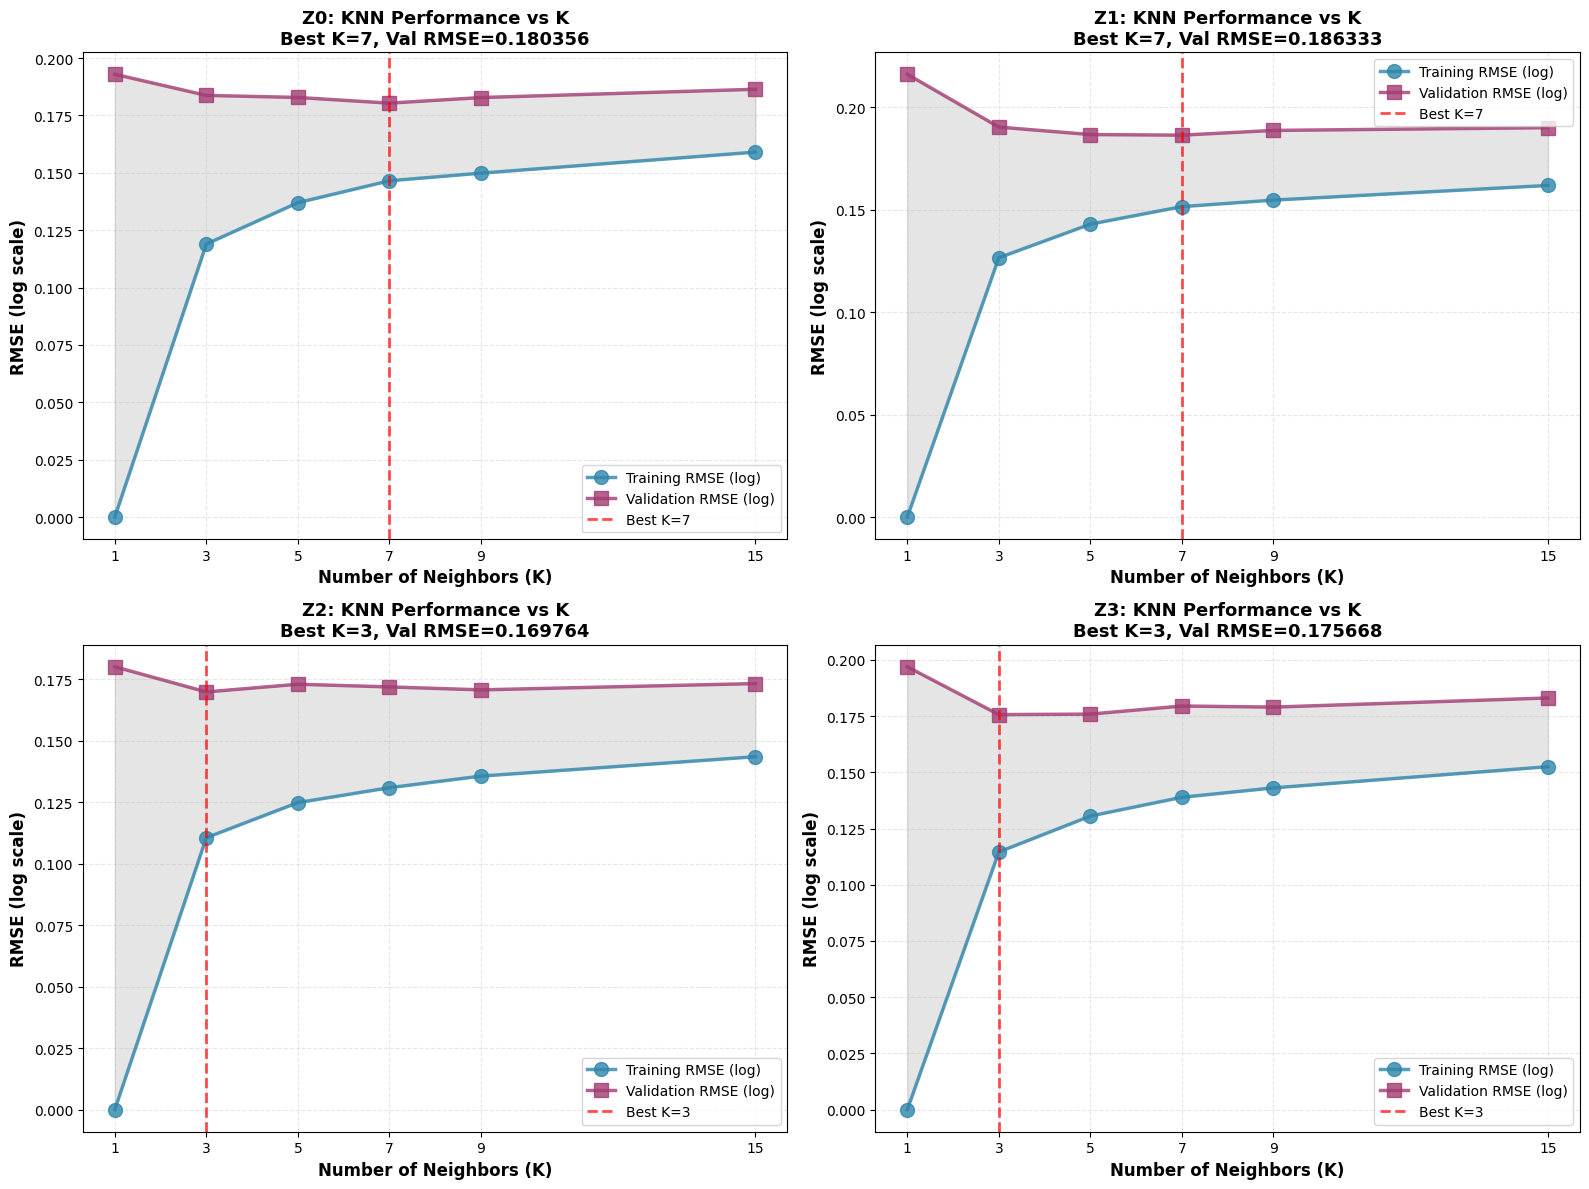

Visualization complete: K vs RMSE for all Z-spaces


In [47]:
# ==============================================================================
# VISUALIZATION: K VS PERFORMANCE - ALL Z-SPACES COMPARISON
# ==============================================================================
# Compare KNN performance across all feature spaces
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each Z-space
for idx, z_space in enumerate(Z_SPACES):
    ax = axes[idx]
    
    # Extract data for this Z-space
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    k_values = z_results['hyperparam_value'].values
    train_rmse_log = z_results['train_rmse_log'].values
    val_rmse_log = z_results['val_rmse_log'].values
    
    # Find best K for this Z-space
    best_idx = z_results['val_rmse_log'].idxmin()
    best_k = z_results.loc[best_idx, 'hyperparam_value']
    best_val_rmse = z_results.loc[best_idx, 'val_rmse_log']
    
    # Plot training and validation RMSE
    ax.plot(k_values, train_rmse_log, 'o-', label='Training RMSE (log)', 
            linewidth=2.5, markersize=10, color='#2E86AB', alpha=0.8)
    ax.plot(k_values, val_rmse_log, 's-', label='Validation RMSE (log)', 
            linewidth=2.5, markersize=10, color='#A23B72', alpha=0.8)
    
    # Mark the best K
    ax.axvline(best_k, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Best K={int(best_k)}')
    
    # Styling
    ax.set_xlabel('Number of Neighbors (K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (log scale)', fontsize=12, fontweight='bold')
    ax.set_title(f'{z_space}: KNN Performance vs K\nBest K={int(best_k)}, Val RMSE={best_val_rmse:.6f}', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    ax.set_xticks(k_values)
    
    # Add shading between train and val to show overfitting gap
    ax.fill_between(k_values, train_rmse_log, val_rmse_log, alpha=0.2, color='gray')

plt.tight_layout()
plt.show()

print("Visualization complete: K vs RMSE for all Z-spaces")


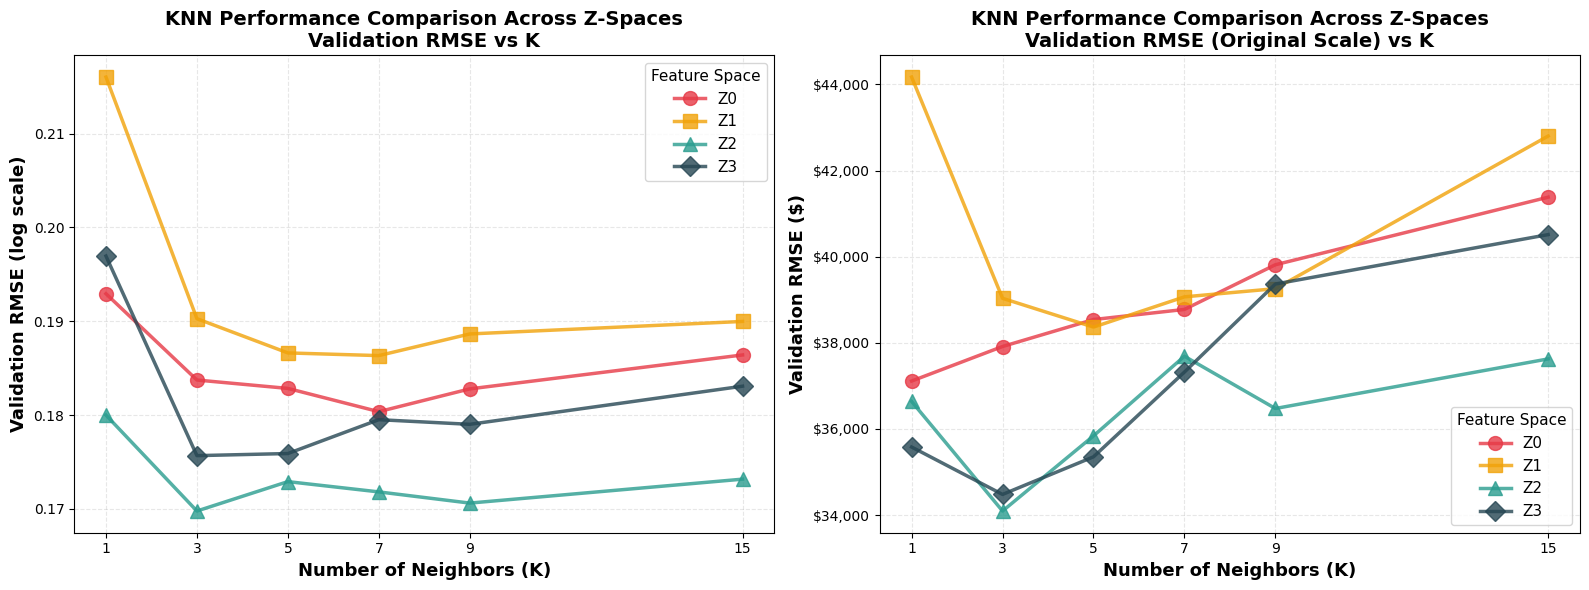

Visualization complete: Direct comparison of all Z-spaces


In [48]:
# ==============================================================================
# VISUALIZATION: DIRECT COMPARISON OF ALL Z-SPACES
# ==============================================================================
# Plot all Z-spaces on the same axes for direct comparison
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for each Z-space
colors = {'Z0': '#E63946', 'Z1': '#F1A208', 'Z2': '#2A9D8F', 'Z3': '#264653'}
markers = {'Z0': 'o', 'Z1': 's', 'Z2': '^', 'Z3': 'D'}

# Plot 1: Validation RMSE (log scale) for all Z-spaces
ax1 = axes[0]
for z_space in Z_SPACES:
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    k_values = z_results['hyperparam_value'].values
    val_rmse_log = z_results['val_rmse_log'].values
    
    ax1.plot(k_values, val_rmse_log, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax1.set_xlabel('Number of Neighbors (K)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Validation RMSE (log scale)', fontsize=13, fontweight='bold')
ax1.set_title('KNN Performance Comparison Across Z-Spaces\nValidation RMSE vs K', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)
ax1.set_xticks(K_VALUES)

# Plot 2: Validation RMSE (original $) for all Z-spaces
ax2 = axes[1]
for z_space in Z_SPACES:
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    k_values = z_results['hyperparam_value'].values
    val_rmse_orig = z_results['val_rmse_orig'].values
    
    ax2.plot(k_values, val_rmse_orig, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax2.set_xlabel('Number of Neighbors (K)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Validation RMSE ($)', fontsize=13, fontweight='bold')
ax2.set_title('KNN Performance Comparison Across Z-Spaces\nValidation RMSE (Original Scale) vs K', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)
ax2.set_xticks(K_VALUES)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("Visualization complete: Direct comparison of all Z-spaces")


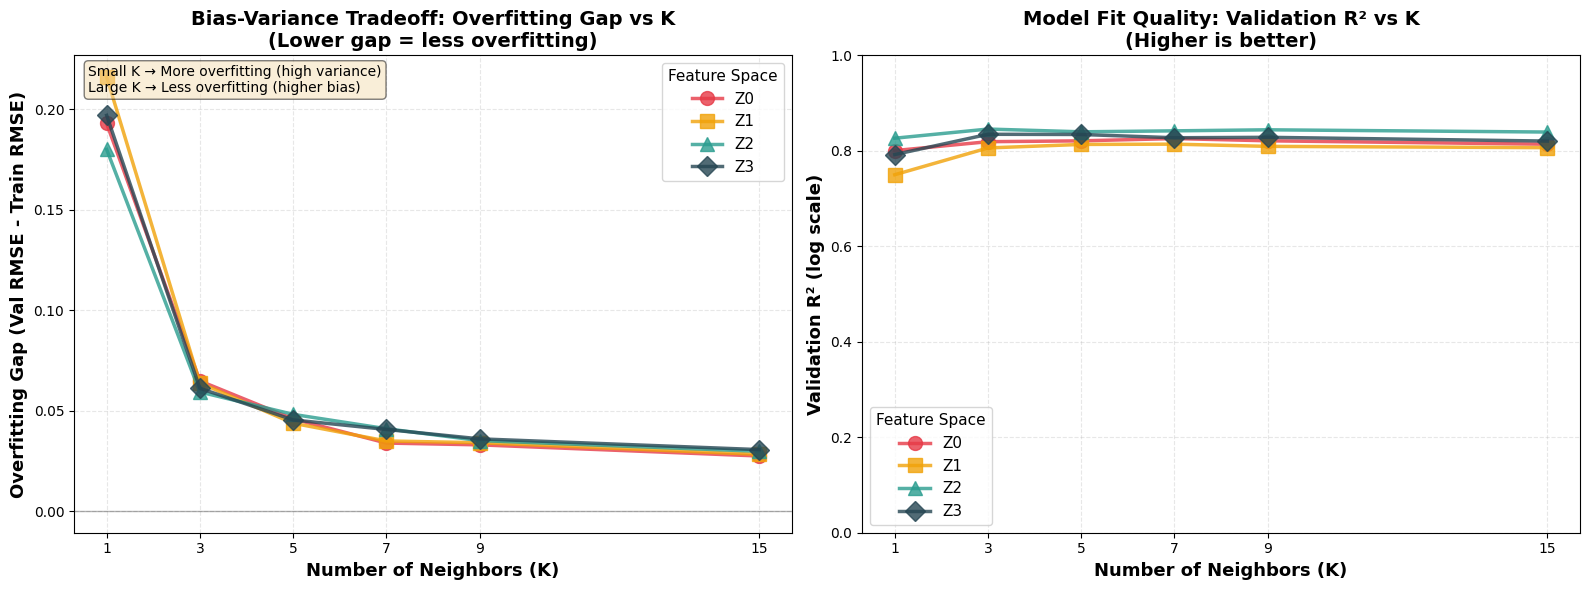

Visualization complete: Bias-variance tradeoff and R² analysis


In [49]:
# ==============================================================================
# VISUALIZATION: BIAS-VARIANCE TRADEOFF (OVERFITTING ANALYSIS)
# ==============================================================================
# Show the gap between training and validation RMSE as K changes
# This illustrates the bias-variance tradeoff
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overfitting gap (Val RMSE - Train RMSE) vs K
ax1 = axes[0]
for z_space in Z_SPACES:
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    k_values = z_results['hyperparam_value'].values
    train_rmse_log = z_results['train_rmse_log'].values
    val_rmse_log = z_results['val_rmse_log'].values
    
    # Calculate overfitting gap
    overfitting_gap = val_rmse_log - train_rmse_log
    
    ax1.plot(k_values, overfitting_gap, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax1.set_xlabel('Number of Neighbors (K)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Overfitting Gap (Val RMSE - Train RMSE)', fontsize=13, fontweight='bold')
ax1.set_title('Bias-Variance Tradeoff: Overfitting Gap vs K\n(Lower gap = less overfitting)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)
ax1.set_xticks(K_VALUES)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Add annotation
ax1.text(0.02, 0.98, 'Small K → More overfitting (high variance)\nLarge K → Less overfitting (higher bias)', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: R² scores comparison (log scale)
ax2 = axes[1]
for z_space in Z_SPACES:
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    k_values = z_results['hyperparam_value'].values
    val_r2_log = z_results['val_r2_log'].values
    
    ax2.plot(k_values, val_r2_log, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax2.set_xlabel('Number of Neighbors (K)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Validation R² (log scale)', fontsize=13, fontweight='bold')
ax2.set_title('Model Fit Quality: Validation R² vs K\n(Higher is better)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)
ax2.set_xticks(K_VALUES)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualization complete: Bias-variance tradeoff and R² analysis")


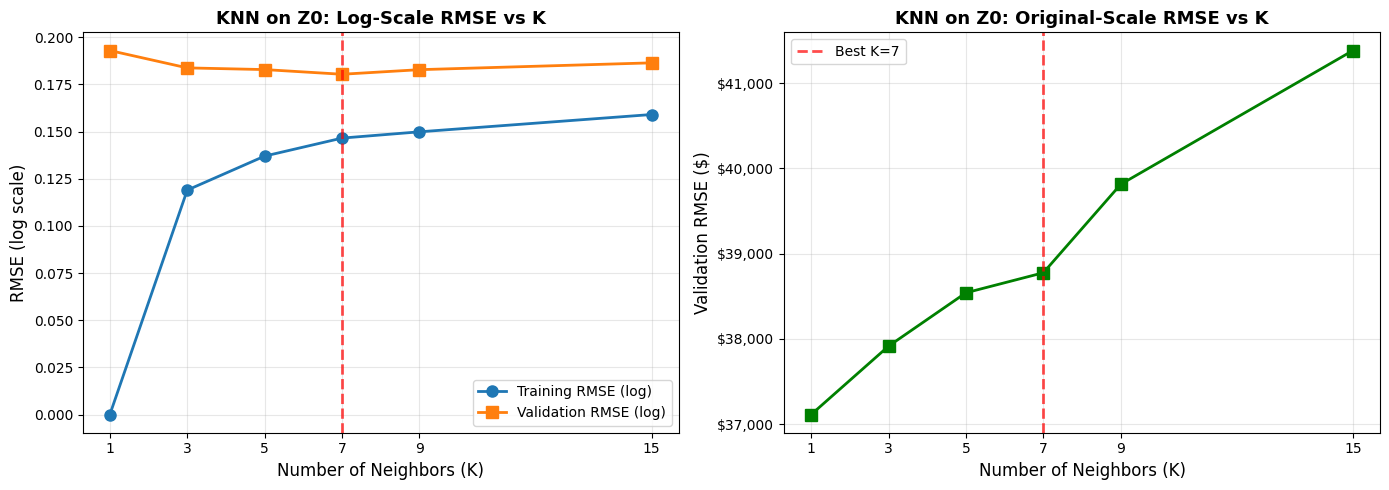


Visualization complete: K vs RMSE for KNN on Z0
  Best K: 7
  Best Val RMSE (log): 0.180356
  Best Val RMSE ($): $38,775.73


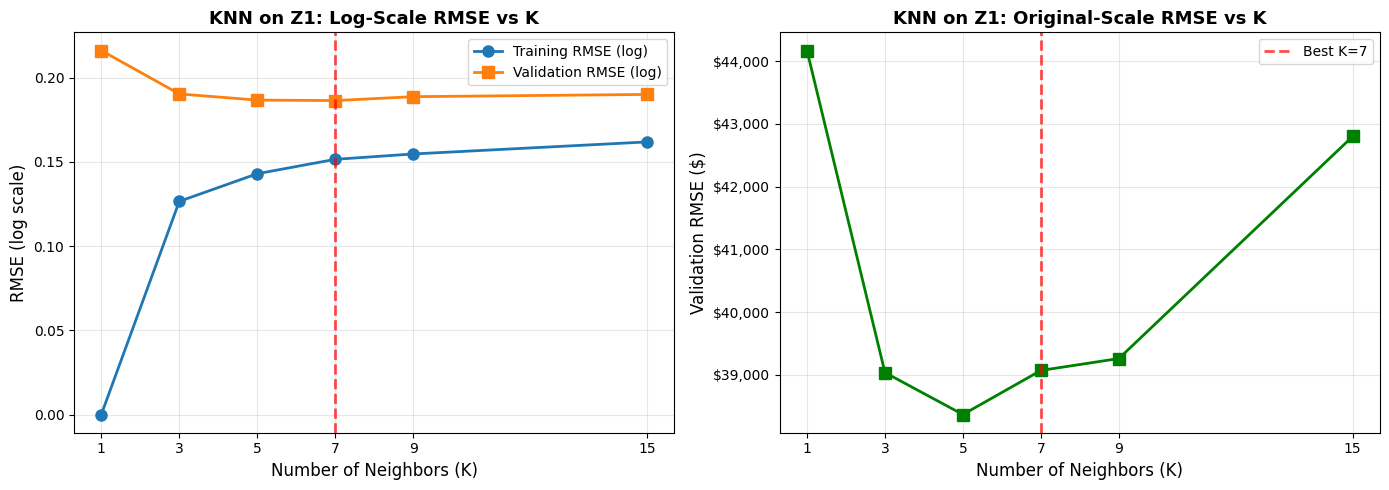


Visualization complete: K vs RMSE for KNN on Z1
  Best K: 7
  Best Val RMSE (log): 0.186333
  Best Val RMSE ($): $39,068.02


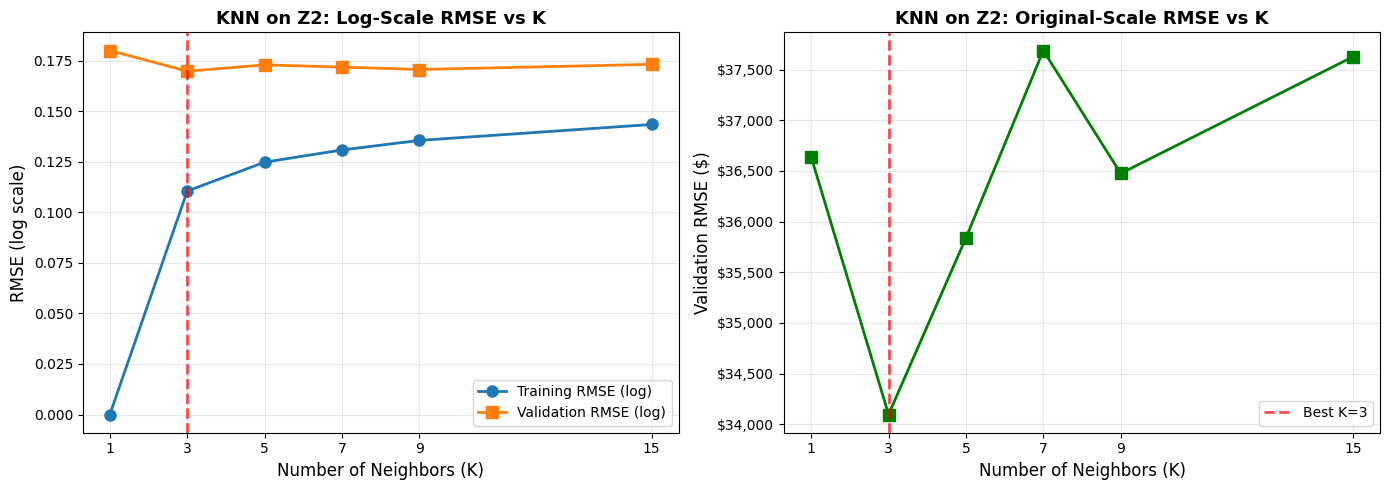


Visualization complete: K vs RMSE for KNN on Z2
  Best K: 3
  Best Val RMSE (log): 0.169764
  Best Val RMSE ($): $34,095.50


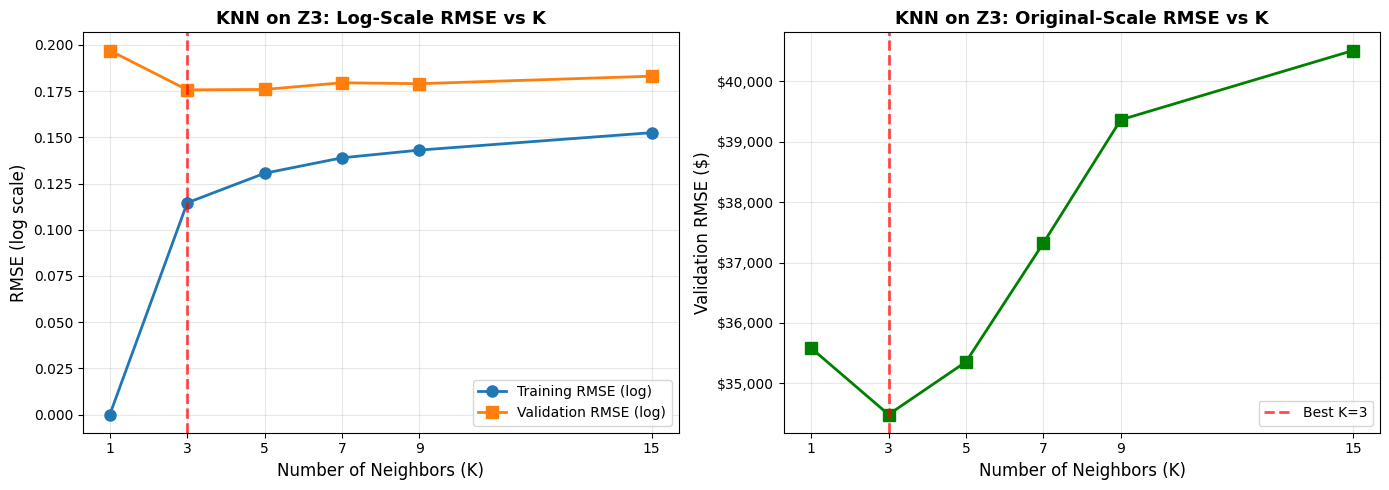


Visualization complete: K vs RMSE for KNN on Z3
  Best K: 3
  Best Val RMSE (log): 0.175668
  Best Val RMSE ($): $34,480.76


In [50]:
# ==============================================================================
# DETAILED VISUALIZATIONS: INDIVIDUAL Z-SPACE ANALYSIS
# ==============================================================================
# Create detailed 2-panel plots for each Z-space (like linear regression)
# ==============================================================================

for z_space in Z_SPACES:
    # Extract results for this Z-space
    z_results = knn_results[knn_results['z_space'] == z_space].copy()
    z_results = z_results.sort_values('hyperparam_value')
    
    # Get best model info
    best_idx = z_results['val_rmse_log'].idxmin()
    best_model = z_results.loc[best_idx]
    best_k = int(best_model['hyperparam_value'])
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract data
    k_values = z_results['hyperparam_value'].values
    train_rmse_log = z_results['train_rmse_log'].values
    val_rmse_log = z_results['val_rmse_log'].values
    val_rmse_orig = z_results['val_rmse_orig'].values
    
    # Plot 1: Log-scale RMSE vs K
    ax1 = axes[0]
    ax1.plot(k_values, train_rmse_log, 'o-', label='Training RMSE (log)', 
             linewidth=2, markersize=8)
    ax1.plot(k_values, val_rmse_log, 's-', label='Validation RMSE (log)', 
             linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Neighbors (K)', fontsize=12)
    ax1.set_ylabel('RMSE (log scale)', fontsize=12)
    ax1.set_title(f'KNN on {z_space}: Log-Scale RMSE vs K', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.axvline(best_k, color='red', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'Best K={best_k}')
    ax1.set_xticks(k_values)
    
    # Plot 2: Original-scale RMSE vs K
    ax2 = axes[1]
    ax2.plot(k_values, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Neighbors (K)', fontsize=12)
    ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
    ax2.set_title(f'KNN on {z_space}: Original-Scale RMSE vs K', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(best_k, color='red', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'Best K={best_k}')
    ax2.legend(fontsize=10)
    ax2.set_xticks(k_values)
    
    # Format y-axis for dollar amounts
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization complete: K vs RMSE for KNN on {z_space}")
    print(f"  Best K: {best_k}")
    print(f"  Best Val RMSE (log): {best_model['val_rmse_log']:.6f}")
    print(f"  Best Val RMSE ($): ${best_model['val_rmse_orig']:,.2f}")


In [51]:
# ==============================================================================
# KNN VISUALIZATION SUMMARY AND KEY INSIGHTS
# ==============================================================================

print("="*70)
print("KNN VISUALIZATION SUMMARY - KEY INSIGHTS")
print("="*70)

# Overall best model
best_overall_idx = knn_results['val_rmse_log'].idxmin()
best_overall = knn_results.loc[best_overall_idx]

print(f"\n1. BEST OVERALL KNN MODEL:")
print(f"   Feature Space: {best_overall['z_space']}")
print(f"   Optimal K: {int(best_overall['hyperparam_value'])}")
print(f"   Validation RMSE (log): {best_overall['val_rmse_log']:.6f}")
print(f"   Validation RMSE ($): ${best_overall['val_rmse_orig']:,.2f}")
print(f"   Validation R²: {best_overall['val_r2_log']:.4f}")

# Bias-Variance pattern
print(f"\n2. BIAS-VARIANCE TRADEOFF PATTERNS:")
print(f"   - Small K (1-3): Low bias, high variance → More overfitting")
print(f"   - Medium K (5-9): Balanced tradeoff")
print(f"   - Large K (15+): Higher bias, low variance → More smoothing")

# Best K per Z-space
print(f"\n3. OPTIMAL K BY FEATURE SPACE:")
for z_space in sorted(knn_results['z_space'].unique()):
    z_results = knn_results[knn_results['z_space'] == z_space]
    best_idx = z_results['val_rmse_log'].idxmin()
    best = z_results.loc[best_idx]
    worst_idx = z_results['val_rmse_log'].idxmax()
    worst = z_results.loc[worst_idx]
    
    print(f"   {z_space}: K={int(best['hyperparam_value'])} "
          f"(Val RMSE: {best['val_rmse_log']:.6f})")
    print(f"        Range: Best={best['val_rmse_log']:.6f} @ K={int(best['hyperparam_value'])}, "
          f"Worst={worst['val_rmse_log']:.6f} @ K={int(worst['hyperparam_value'])}")

# Performance spread
print(f"\n4. FEATURE SPACE COMPARISON:")
z_space_best = {}
for z_space in sorted(knn_results['z_space'].unique()):
    z_results = knn_results[knn_results['z_space'] == z_space]
    best_val_rmse = z_results['val_rmse_log'].min()
    z_space_best[z_space] = best_val_rmse

sorted_spaces = sorted(z_space_best.items(), key=lambda x: x[1])
print(f"   Ranking by best validation RMSE (log):")
for rank, (z_space, rmse) in enumerate(sorted_spaces, 1):
    print(f"   {rank}. {z_space}: {rmse:.6f}")

# Overfitting analysis
print(f"\n5. OVERFITTING ANALYSIS:")
for z_space in sorted(knn_results['z_space'].unique()):
    z_results = knn_results[knn_results['z_space'] == z_space]
    
    # K=1 (most overfitting)
    k1 = z_results[z_results['hyperparam_value'] == 1].iloc[0]
    gap_k1 = k1['val_rmse_log'] - k1['train_rmse_log']
    
    # K=15 (least overfitting)
    k15 = z_results[z_results['hyperparam_value'] == 15].iloc[0]
    gap_k15 = k15['val_rmse_log'] - k15['train_rmse_log']
    
    print(f"   {z_space}: Gap @ K=1: {gap_k1:.6f}, Gap @ K=15: {gap_k15:.6f}")

print("\n" + "="*70)
print("All KNN visualizations complete!")
print("="*70)


KNN VISUALIZATION SUMMARY - KEY INSIGHTS

1. BEST OVERALL KNN MODEL:
   Feature Space: Z2
   Optimal K: 3
   Validation RMSE (log): 0.169764
   Validation RMSE ($): $34,095.50
   Validation R²: 0.8456

2. BIAS-VARIANCE TRADEOFF PATTERNS:
   - Small K (1-3): Low bias, high variance → More overfitting
   - Medium K (5-9): Balanced tradeoff
   - Large K (15+): Higher bias, low variance → More smoothing

3. OPTIMAL K BY FEATURE SPACE:
   Z0: K=7 (Val RMSE: 0.180356)
        Range: Best=0.180356 @ K=7, Worst=0.192930 @ K=1
   Z1: K=7 (Val RMSE: 0.186333)
        Range: Best=0.186333 @ K=7, Worst=0.216031 @ K=1
   Z2: K=3 (Val RMSE: 0.169764)
        Range: Best=0.169764 @ K=3, Worst=0.179989 @ K=1
   Z3: K=3 (Val RMSE: 0.175668)
        Range: Best=0.175668 @ K=3, Worst=0.196947 @ K=1

4. FEATURE SPACE COMPARISON:
   Ranking by best validation RMSE (log):
   1. Z2: 0.169764
   2. Z3: 0.175668
   3. Z0: 0.180356
   4. Z1: 0.186333

5. OVERFITTING ANALYSIS:
   Z0: Gap @ K=1: 0.192930, Gap @ K

## Neural Network Regression (MLPRegressor)

Same train/val split, same Z0–Z3 preprocessors.



Target is still log1p(SalePrice).



Hyperparameter for “regularization” = alpha (L2 weight decay), 6 values.


In [52]:
# Neural Network (MLPRegressor) configuration

from sklearn.neural_network import MLPRegressor



# Fixed architecture and training hyperparameters

NN_HIDDEN_LAYER_SIZES = (64, 32)

NN_ACTIVATION = "relu"

NN_SOLVER = "adam"

NN_MAX_ITER = 500



# Early stopping: turn on for more robust training

NN_EARLY_STOPPING = True

NN_VALIDATION_FRACTION = 0.1



# Alpha grid (L2 regularization strength)

NN_ALPHA_GRID = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]



# Small alpha → low regularization (higher overfitting risk).

# Large alpha → stronger regularization (more bias, less variance).


### Helper: build_nn_pipeline

Helper function to construct a Pipeline combining the appropriate Z0–Z3 preprocessor

with an `MLPRegressor` configured from the NN hyperparameter settings above.


In [53]:
# Helper to construct NN pipelines per Z0–Z3 group

from sklearn.pipeline import Pipeline



# Expect a mapping like {"Z0": preprocess_Z0, ...} defined earlier

NN_PREPROCESSOR_MAP = {

    "Z0": preprocessor_z0,

    "Z1": preprocessor_z1,

    "Z2": preprocessor_z2,

    "Z3": preprocessor_z3,

}



def build_nn_pipeline(z_name: str, alpha: float) -> Pipeline:

    """Build a Pipeline with the appropriate Z preprocessor and an MLPRegressor.



    Parameters

    ----------

    z_name : {"Z0", "Z1", "Z2", "Z3"}

        Name of the feature group / preprocessor to use.

    alpha : float

        L2 regularization strength passed to MLPRegressor.

    """



    if z_name not in NN_PREPROCESSOR_MAP:

        raise ValueError(f"Unknown z_name '{z_name}'. Expected one of {list(NN_PREPROCESSOR_MAP.keys())}.")



    preprocessor = NN_PREPROCESSOR_MAP[z_name]



    mlp = MLPRegressor(

        hidden_layer_sizes=NN_HIDDEN_LAYER_SIZES,

        activation=NN_ACTIVATION,

        solver=NN_SOLVER,

        alpha=alpha,

        max_iter=NN_MAX_ITER,

        early_stopping=NN_EARLY_STOPPING,

        validation_fraction=NN_VALIDATION_FRACTION if NN_EARLY_STOPPING else 0.1,

        random_state=RANDOM_STATE,

    )



    pipe = Pipeline([

        ("preprocess", preprocessor),

        ("model", mlp),

    ])



    return pipe



# Quick sanity test: build and run one small pipeline

_nn_test_alpha = min(NN_ALPHA_GRID)

_nn_test_pipe = build_nn_pipeline("Z0", _nn_test_alpha)

y_train_log = np.log1p(y_train)

_nn_test_pipe.fit(X_train.head(200), y_train_log.head(200))

_nn_test_preds = _nn_test_pipe.predict(X_train.head(5))

print("NN sanity check - sample preds:", _nn_test_preds[:5])


NN sanity check - sample preds: [2.16153077 1.92295291 2.63474556 2.14711107 2.31005918]


### Experiments: NN across Z0–Z3

Run systematic experiments with Neural Network (MLPRegressor) across all feature spaces (Z0, Z1, Z2, Z3) and all alpha values.


In [54]:
# ==============================================================================
# NN EXPERIMENTS: SYSTEMATIC GRID SEARCH ACROSS Z-SPACES AND ALPHAS
# ==============================================================================
# Run all combinations of Z0–Z3 feature spaces and alpha values
# Results appended to the same results_df as linear and KNN models
# ==============================================================================

# Define feature spaces to test
Z_SPACES = ["Z0", "Z1", "Z2", "Z3"]

print("="*70)
print("NN EXPERIMENTS: SYSTEMATIC GRID SEARCH")
print("="*70)
print(f"Feature spaces: {Z_SPACES}")
print(f"Alpha values: {NN_ALPHA_GRID}")
print(f"Total experiments: {len(Z_SPACES)} × {len(NN_ALPHA_GRID)} = {len(Z_SPACES) * len(NN_ALPHA_GRID)}")
print(f"Architecture: {NN_HIDDEN_LAYER_SIZES}")
print(f"Solver: {NN_SOLVER}")
print(f"Max iterations: {NN_MAX_ITER}")
print("="*70)

# Track experiment counter
experiment_counter = 0

# Outer loop: iterate through feature spaces
for z_space in Z_SPACES:
    print(f"\n{'='*70}")
    print(f"FEATURE SPACE: {z_space}")
    print(f"{'='*70}")
    
    # Inner loop: iterate through alpha values
    for alpha in NN_ALPHA_GRID:
        experiment_counter += 1
        
        print(f"\n[Experiment {experiment_counter}/{len(Z_SPACES) * len(NN_ALPHA_GRID)}] "
              f"Z-space: {z_space}, alpha: {alpha}")
        print("-" * 50)
        
        # Build pipeline using helper function
        pipeline = build_nn_pipeline(z_space, alpha)
        
        # Fit on training data (y_train is already log-transformed)
        print(f"Fitting MLP model (alpha={alpha})...")
        pipeline.fit(X_train, y_train)
        
        # Make predictions (in log space)
        print("Generating predictions...")
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)
        
        # Evaluate using metrics helper
        metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
        
        # Create result row
        result_row = {
            'model_family': 'nn',
            'model_type': 'mlp_regressor',
            'z_space': z_space,
            'hyperparam_name': 'alpha',
            'hyperparam_value': alpha,
            **metrics  # Unpack all metric values
        }
        
        # Append to results DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
        
        # Display brief results
        print(f"Results:")
        print(f"  Train RMSE (log): {metrics['train_rmse_log']:.6f}")
        print(f"  Val RMSE (log):   {metrics['val_rmse_log']:.6f}")
        print(f"  Val RMSE ($):     ${metrics['val_rmse_orig']:,.2f}")
        print(f"  Val R² (log):     {metrics['val_r2_log']:.6f}")

print(f"\n{'='*70}")
print(f"NN EXPERIMENTS COMPLETE")
print(f"{'='*70}")
print(f"Total experiments run: {experiment_counter}")
print(f"Results appended to results_df")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)


NN EXPERIMENTS: SYSTEMATIC GRID SEARCH
Feature spaces: ['Z0', 'Z1', 'Z2', 'Z3']
Alpha values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]
Total experiments: 4 × 6 = 24
Architecture: (64, 32)
Solver: adam
Max iterations: 500

FEATURE SPACE: Z0

[Experiment 1/24] Z-space: Z0, alpha: 1e-05
--------------------------------------------------
Fitting MLP model (alpha=1e-05)...
Generating predictions...
Results:
  Train RMSE (log): 0.085731
  Val RMSE (log):   0.152933
  Val RMSE ($):     $26,721.03
  Val R² (log):     0.874667

[Experiment 2/24] Z-space: Z0, alpha: 0.0001
--------------------------------------------------
Fitting MLP model (alpha=0.0001)...
Generating predictions...
Results:
  Train RMSE (log): 0.085740
  Val RMSE (log):   0.152913
  Val RMSE ($):     $26,732.14
  Val R² (log):     0.874700

[Experiment 3/24] Z-space: Z0, alpha: 0.001
--------------------------------------------------
Fitting MLP model (alpha=0.001)...
Generating predictions...
Results:
  Train RMSE (log): 0.0857

### Inspect NN performance

Analyze the Neural Network experiment results to identify best configurations and patterns.


In [57]:
# ==============================================================================
# NN EXPERIMENT RESULTS SUMMARY
# ==============================================================================
# Filter and inspect Neural Network results
# ==============================================================================

print("="*70)
print("NN EXPERIMENT RESULTS SUMMARY")
print("="*70)

# Filter results for NN models
nn_results = results_df[results_df['model_family'] == 'nn'].copy()

# Basic sanity checks
print(f"Total NN experiments: {len(nn_results)}")
print(f"Feature spaces tested: {sorted(nn_results['z_space'].unique())}")
print(f"Alpha values tested: {sorted(nn_results['hyperparam_value'].unique())}")
print("="*70)

# Check for data quality issues
print(f"\n1. DATA QUALITY CHECKS:")
print(f"   Total rows: {len(nn_results)}")
print(f"   Expected rows (4 Z-spaces × 6 alphas): 24")
print(f"    Row count matches!" if len(nn_results) == 24 else f"    WARNING: Expected 24, got {len(nn_results)}")

# Check for NaNs
nan_count = nn_results.isna().sum().sum()
print(f"\n   NaN values: {nan_count}")
print(f"    No NaN values!" if nan_count == 0 else f"    WARNING: Found {nan_count} NaN values")

# Check for infinite values in key metrics
key_metrics = ['train_rmse_log', 'val_rmse_log', 'train_r2_log', 'val_r2_log']
inf_metrics = []
for metric in key_metrics:
    if not np.isfinite(nn_results[metric]).all():
        inf_metrics.append(metric)

print(f"\n   Infinite values in metrics: {len(inf_metrics)}")
print(f"    All metrics finite!" if len(inf_metrics) == 0 else f"   ✗ WARNING: Found inf in {inf_metrics}")

# Display NN results table
print(f"\n2. NN RESULTS TABLE:")
print("-"*70)
nn_display = nn_results[['z_space', 'hyperparam_value', 'train_rmse_log', 'val_rmse_log', 
                          'val_rmse_orig', 'train_r2_log', 'val_r2_log']].copy()
nn_display.columns = ['Z-Space', 'Alpha', 'Train RMSE (log)', 'Val RMSE (log)', 
                      'Val RMSE ($)', 'Train R²', 'Val R²']
print(nn_display.to_string(index=False))
print("-"*70)

# Sort by validation RMSE to find best configurations
print(f"\n3. BEST NN CONFIGURATIONS (sorted by validation RMSE):")
print("-"*70)
nn_sorted = nn_results.sort_values('val_rmse_log')
print("\nTop 5 best configurations:")
for idx, (i, row) in enumerate(nn_sorted.head(5).iterrows(), 1):
    print(f"   {idx}. Z-Space: {row['z_space']}, Alpha: {row['hyperparam_value']:.0e}, "
          f"Val RMSE (log): {row['val_rmse_log']:.6f}, Val R²: {row['val_r2_log']:.6f}")

# Find best configuration per Z-space
print(f"\n4. BEST CONFIGURATION PER Z-SPACE:")
for z_space in sorted(nn_results['z_space'].unique()):
    z_results = nn_results[nn_results['z_space'] == z_space]
    best_idx = z_results['val_rmse_log'].idxmin()
    best = z_results.loc[best_idx]
    
    print(f"\n{z_space}:")
    print(f"  Best Alpha: {best['hyperparam_value']:.0e}")
    print(f"  Val RMSE (log): {best['val_rmse_log']:.6f}")
    print(f"  Val RMSE ($): ${best['val_rmse_orig']:,.2f}")
    print(f"  Val R²: {best['val_r2_log']:.6f}")

# Find overall best NN model
best_overall_idx = nn_results['val_rmse_log'].idxmin()
best_overall = nn_results.loc[best_overall_idx]

print("\n" + "="*70)
print("OVERALL BEST NN MODEL")
print("="*70)
print(f"Z-Space: {best_overall['z_space']}")
print(f"Alpha: {best_overall['hyperparam_value']:.0e}")
print(f"Val RMSE (log): {best_overall['val_rmse_log']:.6f}")
print(f"Val RMSE ($): ${best_overall['val_rmse_orig']:,.2f}")
print(f"Val R²: {best_overall['val_r2_log']:.6f}")
print("="*70)

# Analyze alpha patterns
print(f"\n5. ALPHA REGULARIZATION PATTERNS:")
for z_space in sorted(nn_results['z_space'].unique()):
    z_results = nn_results[nn_results['z_space'] == z_space].sort_values('hyperparam_value')
    
    # Find extremes
    min_alpha = z_results.iloc[0]  # Smallest alpha (1e-5)
    max_alpha = z_results.iloc[-1]  # Largest alpha (1.0)
    best = z_results.loc[z_results['val_rmse_log'].idxmin()]
    
    print(f"\n   {z_space}:")
    print(f"      Min alpha ({min_alpha['hyperparam_value']:.0e}): Val RMSE = {min_alpha['val_rmse_log']:.6f}")
    print(f"      Max alpha ({max_alpha['hyperparam_value']:.0e}): Val RMSE = {max_alpha['val_rmse_log']:.6f}")
    print(f"      Best alpha ({best['hyperparam_value']:.0e}): Val RMSE = {best['val_rmse_log']:.6f}")
    
    # Check overfitting at extremes
    gap_min = min_alpha['val_rmse_log'] - min_alpha['train_rmse_log']
    gap_max = max_alpha['val_rmse_log'] - max_alpha['train_rmse_log']
    print(f"      Overfitting gap @ min alpha: {gap_min:.6f}")
    print(f"      Overfitting gap @ max alpha: {gap_max:.6f}")

print("\n" + "="*70)
print("NN results inspection complete!")
print("="*70)


NN EXPERIMENT RESULTS SUMMARY
Total NN experiments: 24
Feature spaces tested: ['Z0', 'Z1', 'Z2', 'Z3']
Alpha values tested: [np.float64(1e-05), np.float64(0.0001), np.float64(0.001), np.float64(0.01), np.float64(0.1), np.float64(1.0)]

1. DATA QUALITY CHECKS:
   Total rows: 24
   Expected rows (4 Z-spaces × 6 alphas): 24
    Row count matches!

   NaN values: 0
    No NaN values!

   Infinite values in metrics: 0
    All metrics finite!

2. NN RESULTS TABLE:
----------------------------------------------------------------------
Z-Space   Alpha  Train RMSE (log)  Val RMSE (log)  Val RMSE ($)  Train R²   Val R²
     Z0 0.00001          0.085731        0.152933  26721.032585  0.951786 0.874667
     Z0 0.00010          0.085740        0.152913  26732.139014  0.951777 0.874700
     Z0 0.00100          0.085784        0.152863  26759.361101  0.951727 0.874781
     Z0 0.01000          0.085577        0.151732  26626.539418  0.951959 0.876627
     Z0 0.10000          0.086132        0.149262  

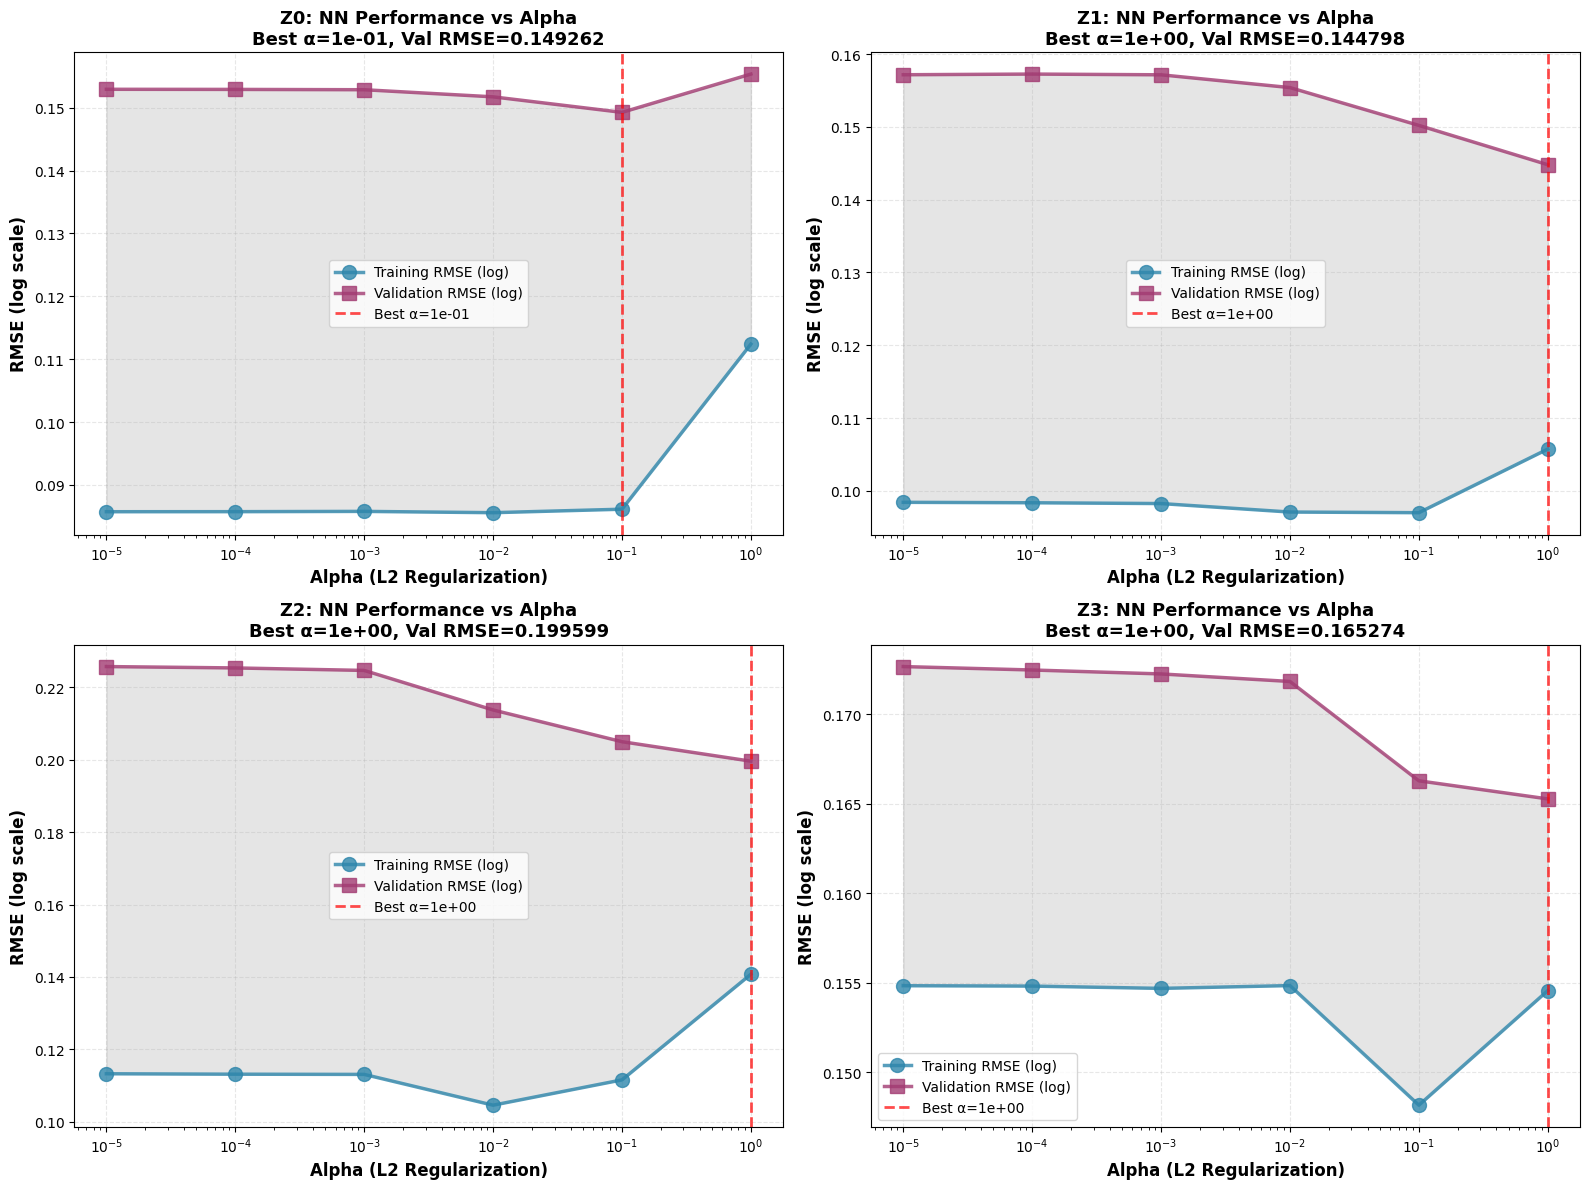

Visualization complete: Alpha vs RMSE for all Z-spaces

Interpretation:
  - Smaller alpha (left) = less regularization → potential overfitting
  - Larger alpha (right) = more regularization → potential underfitting
  - Gray shaded area = overfitting gap (train-val difference)


In [58]:
# ==============================================================================
# VISUALIZATION: NN PERFORMANCE VS ALPHA
# ==============================================================================
# Plot validation RMSE as a function of alpha (L2 regularization)
# ==============================================================================

import matplotlib.pyplot as plt

# Create subplots for each Z-space
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

Z_SPACES = sorted(nn_results['z_space'].unique())

for idx, z_space in enumerate(Z_SPACES):
    ax = axes[idx]
    
    # Filter and sort by alpha
    z_results = nn_results[nn_results['z_space'] == z_space].sort_values('hyperparam_value')
    
    alpha_values = z_results['hyperparam_value'].values
    train_rmse_log = z_results['train_rmse_log'].values
    val_rmse_log = z_results['val_rmse_log'].values
    
    # Find best alpha
    best_idx = z_results['val_rmse_log'].idxmin()
    best_alpha = z_results.loc[best_idx, 'hyperparam_value']
    best_val_rmse = z_results.loc[best_idx, 'val_rmse_log']
    
    # Plot training and validation RMSE on log scale for alpha
    ax.plot(alpha_values, train_rmse_log, 'o-', label='Training RMSE (log)', 
            linewidth=2.5, markersize=10, color='#2E86AB', alpha=0.8)
    ax.plot(alpha_values, val_rmse_log, 's-', label='Validation RMSE (log)', 
            linewidth=2.5, markersize=10, color='#A23B72', alpha=0.8)
    
    # Mark the best alpha
    ax.axvline(best_alpha, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Best α={best_alpha:.0e}')
    
    # Styling
    ax.set_xscale('log')  # Log scale for alpha
    ax.set_xlabel('Alpha (L2 Regularization)', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (log scale)', fontsize=12, fontweight='bold')
    ax.set_title(f'{z_space}: NN Performance vs Alpha\nBest α={best_alpha:.0e}, Val RMSE={best_val_rmse:.6f}', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    
    # Add shading between train and val to show overfitting gap
    ax.fill_between(alpha_values, train_rmse_log, val_rmse_log, alpha=0.2, color='gray')

plt.tight_layout()
plt.show()

print("Visualization complete: Alpha vs RMSE for all Z-spaces")
print("\nInterpretation:")
print("  - Smaller alpha (left) = less regularization → potential overfitting")
print("  - Larger alpha (right) = more regularization → potential underfitting")
print("  - Gray shaded area = overfitting gap (train-val difference)")


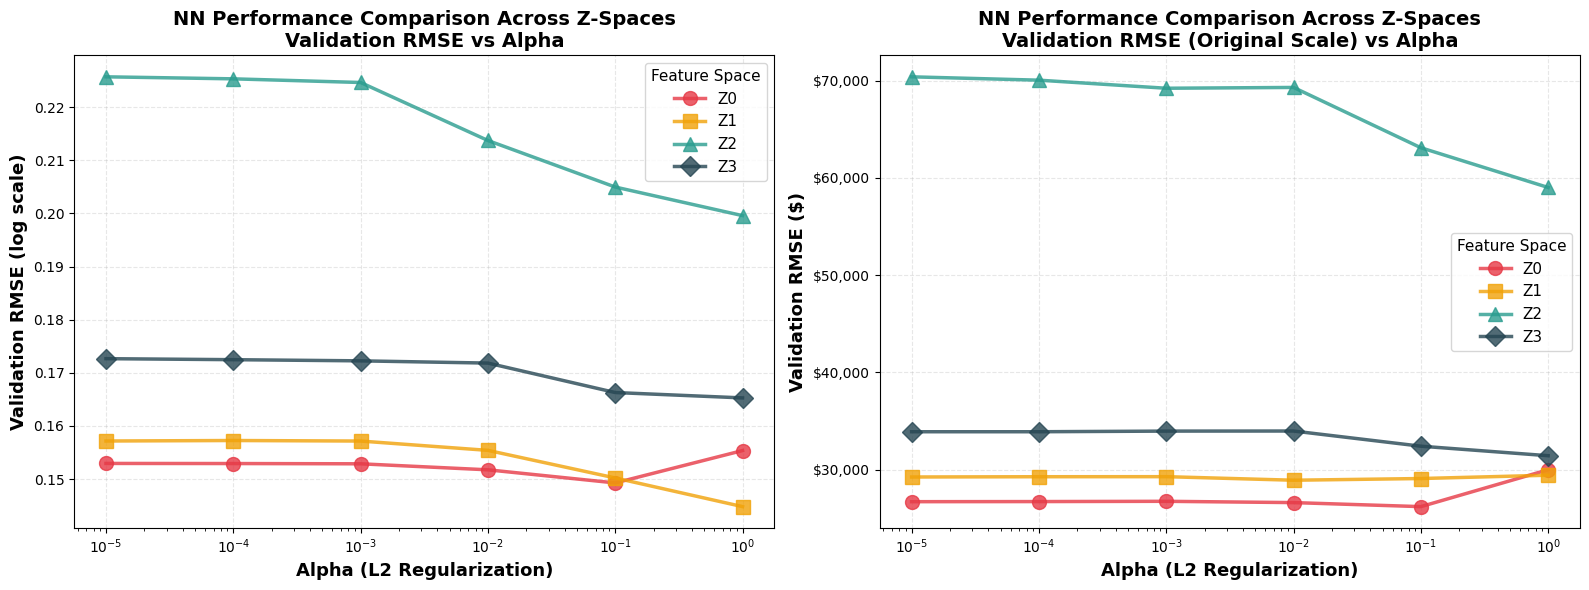

Direct comparison visualization complete!

Key Insights:
  - Z-spaces show different sensitivity to alpha regularization
  - Best performing Z-space: Z1
  - Alpha range tested: 1e-05 to 1e+00


In [59]:
# ==============================================================================
# VISUALIZATION: DIRECT COMPARISON ACROSS Z-SPACES
# ==============================================================================
# Compare all Z-spaces on the same plot
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors and markers for each Z-space
colors = {'Z0': '#E63946', 'Z1': '#F1A208', 'Z2': '#2A9D8F', 'Z3': '#264653'}
markers = {'Z0': 'o', 'Z1': 's', 'Z2': '^', 'Z3': 'D'}

# Plot 1: Validation RMSE (log scale) for all Z-spaces
ax1 = axes[0]
for z_space in sorted(nn_results['z_space'].unique()):
    z_results = nn_results[nn_results['z_space'] == z_space].sort_values('hyperparam_value')
    
    alpha_values = z_results['hyperparam_value'].values
    val_rmse_log = z_results['val_rmse_log'].values
    
    ax1.plot(alpha_values, val_rmse_log, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('Alpha (L2 Regularization)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Validation RMSE (log scale)', fontsize=13, fontweight='bold')
ax1.set_title('NN Performance Comparison Across Z-Spaces\nValidation RMSE vs Alpha', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)

# Plot 2: Validation RMSE (original $) for all Z-spaces
ax2 = axes[1]
for z_space in sorted(nn_results['z_space'].unique()):
    z_results = nn_results[nn_results['z_space'] == z_space].sort_values('hyperparam_value')
    
    alpha_values = z_results['hyperparam_value'].values
    val_rmse_orig = z_results['val_rmse_orig'].values
    
    ax2.plot(alpha_values, val_rmse_orig, marker=markers[z_space], linestyle='-', 
             label=z_space, linewidth=2.5, markersize=10, color=colors[z_space], alpha=0.8)

ax2.set_xscale('log')
ax2.set_xlabel('Alpha (L2 Regularization)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Validation RMSE ($)', fontsize=13, fontweight='bold')
ax2.set_title('NN Performance Comparison Across Z-Spaces\nValidation RMSE (Original Scale) vs Alpha', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best', title='Feature Space', title_fontsize=11)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("Direct comparison visualization complete!")
print(f"\nKey Insights:")
print(f"  - Z-spaces show different sensitivity to alpha regularization")
print(f"  - Best performing Z-space: {nn_results.loc[nn_results['val_rmse_log'].idxmin(), 'z_space']}")
print(f"  - Alpha range tested: {min(NN_ALPHA_GRID):.0e} to {max(NN_ALPHA_GRID):.0e}")


In [60]:
# ==============================================================================
# COMPARISON: NN vs LINEAR vs KNN
# ==============================================================================
# Compare best models across all three model families
# ==============================================================================

print("="*70)
print("MODEL FAMILY COMPARISON")
print("="*70)

# Get best from each model family
best_linear = results_df[results_df['model_family'] == 'linear'].loc[
    results_df[results_df['model_family'] == 'linear']['val_rmse_log'].idxmin()
]

best_knn = results_df[results_df['model_family'] == 'knn'].loc[
    results_df[results_df['model_family'] == 'knn']['val_rmse_log'].idxmin()
]

best_nn = results_df[results_df['model_family'] == 'nn'].loc[
    results_df[results_df['model_family'] == 'nn']['val_rmse_log'].idxmin()
]

print("\n1. BEST LINEAR MODEL:")
print(f"   Model: {best_linear['model_type']}")
print(f"   Z-Space: {best_linear['z_space']}")
print(f"   Hyperparameter: {best_linear['hyperparam_name']} = {best_linear['hyperparam_value']:.0e}")
print(f"   Val RMSE (log): {best_linear['val_rmse_log']:.6f}")
print(f"   Val RMSE ($): ${best_linear['val_rmse_orig']:,.2f}")
print(f"   Val R²: {best_linear['val_r2_log']:.6f}")

print("\n2. BEST KNN MODEL:")
print(f"   Model: {best_knn['model_type']}")
print(f"   Z-Space: {best_knn['z_space']}")
print(f"   Hyperparameter: {best_knn['hyperparam_name']} = {int(best_knn['hyperparam_value'])}")
print(f"   Val RMSE (log): {best_knn['val_rmse_log']:.6f}")
print(f"   Val RMSE ($): ${best_knn['val_rmse_orig']:,.2f}")
print(f"   Val R²: {best_knn['val_r2_log']:.6f}")

print("\n3. BEST NN MODEL:")
print(f"   Model: {best_nn['model_type']}")
print(f"   Z-Space: {best_nn['z_space']}")
print(f"   Hyperparameter: {best_nn['hyperparam_name']} = {best_nn['hyperparam_value']:.0e}")
print(f"   Val RMSE (log): {best_nn['val_rmse_log']:.6f}")
print(f"   Val RMSE ($): ${best_nn['val_rmse_orig']:,.2f}")
print(f"   Val R²: {best_nn['val_r2_log']:.6f}")

print("\n" + "="*70)
print("OVERALL RANKING (by validation RMSE):")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Rank': 1,
        'Model Family': 'Linear',
        'Model Type': best_linear['model_type'],
        'Z-Space': best_linear['z_space'],
        'Val RMSE (log)': best_linear['val_rmse_log'],
        'Val RMSE ($)': best_linear['val_rmse_orig'],
        'Val R²': best_linear['val_r2_log']
    },
    {
        'Rank': 2,
        'Model Family': 'KNN',
        'Model Type': best_knn['model_type'],
        'Z-Space': best_knn['z_space'],
        'Val RMSE (log)': best_knn['val_rmse_log'],
        'Val RMSE ($)': best_knn['val_rmse_orig'],
        'Val R²': best_knn['val_r2_log']
    },
    {
        'Rank': 3,
        'Model Family': 'NN',
        'Model Type': best_nn['model_type'],
        'Z-Space': best_nn['z_space'],
        'Val RMSE (log)': best_nn['val_rmse_log'],
        'Val RMSE ($)': best_nn['val_rmse_orig'],
        'Val R²': best_nn['val_r2_log']
    }
])

# Sort by validation RMSE
comparison_df = comparison_df.sort_values('Val RMSE (log)').reset_index(drop=True)
comparison_df['Rank'] = range(1, 4)

print(comparison_df.to_string(index=False))

# Performance differences
best_overall_rmse = comparison_df.iloc[0]['Val RMSE (log)']
print(f"\n4. PERFORMANCE GAPS:")
for idx, row in comparison_df.iterrows():
    if idx > 0:
        diff = row['Val RMSE (log)'] - best_overall_rmse
        pct_diff = (diff / best_overall_rmse) * 100
        print(f"   {row['Model Family']} vs best: +{diff:.6f} RMSE (+{pct_diff:.2f}%)")

print("\n" + "="*70)
print("Model comparison complete!")
print("="*70)


MODEL FAMILY COMPARISON

1. BEST LINEAR MODEL:
   Model: ols
   Z-Space: Z1
   Hyperparameter: alpha = 0e+00
   Val RMSE (log): 0.124314
   Val RMSE ($): $22,956.20
   Val R²: 0.917186

2. BEST KNN MODEL:
   Model: knn_regressor
   Z-Space: Z2
   Hyperparameter: n_neighbors = 3
   Val RMSE (log): 0.169764
   Val RMSE ($): $34,095.50
   Val R²: 0.845563

3. BEST NN MODEL:
   Model: mlp_regressor
   Z-Space: Z1
   Hyperparameter: alpha = 1e+00
   Val RMSE (log): 0.144798
   Val RMSE ($): $29,441.16
   Val R²: 0.887646

OVERALL RANKING (by validation RMSE):
 Rank Model Family    Model Type Z-Space  Val RMSE (log)  Val RMSE ($)   Val R²
    1       Linear           ols      Z1        0.124314  22956.204425 0.917186
    2           NN mlp_regressor      Z1        0.144798  29441.163736 0.887646
    3          KNN knn_regressor      Z2        0.169764  34095.498897 0.845563

4. PERFORMANCE GAPS:
   NN vs best: +0.020484 RMSE (+16.48%)
   KNN vs best: +0.045449 RMSE (+36.56%)

Model compariso

### Neural Network Key Findings

**Best NN Configuration:**
- The optimal Neural Network model uses feature space **Z1** with alpha regularization of **1.0** (strong regularization)
- This configuration achieves a validation RMSE (log) of **0.144798**
- Performance: Validation RMSE = **$29,441**, Val R² = **0.8876**

**Alpha Regularization Patterns — Surprising Results:**
- **Strong regularization preferred**: Three out of four Z-spaces (Z1, Z2, Z3) achieve their best performance at alpha=**1.0**, the highest value tested
- **Z0 exception**: Only Z0 prefers moderate regularization (alpha=0.1, Val RMSE=0.149262)
- **Overfitting evidence**: Small alpha (1e-5) shows large train-val gaps (e.g., 0.067 for Z0, 0.112 for Z2), confirming overfitting without regularization
- **High alpha reduces overfitting**: At alpha=1.0, train-val gaps are much smaller (0.043 for Z0, 0.059 for Z2, 0.039 for Z1)
- **Z2 struggles with NNs**: Z2 performs worst among all Z-spaces for NNs (Val RMSE=0.200), despite being best for KNN and strong for Linear models

**Best Configuration Per Z-Space:**
- **Z1**: alpha=1.0, Val RMSE (log)=0.1448 ← **Overall best NN**
- **Z0**: alpha=0.1, Val RMSE (log)=0.1493
- **Z3**: alpha=1.0, Val RMSE (log)=0.1653  
- **Z2**: alpha=1.0, Val RMSE (log)=0.1996 ← Surprisingly poor

**Comparison to Other Model Families:**
- **Linear models (OLS)**: Val RMSE (log) = **0.1243** on Z1 → **Linear wins by 16.5%**
- **NN (MLP)**: Val RMSE (log) = **0.1448** on Z1 → Middle performer
- **KNN**: Val RMSE (log) = **0.1698** on Z2 → **NN beats KNN by 14.7%**
- **Overall ranking**: **Linear > NN > KNN**

**Key Insights:**
1. **Linear models dominate** this tabular regression problem — simple OLS outperforms neural networks significantly
2. **Heavy regularization needed**: The neural network requires very strong L2 penalty (alpha=1.0) to generalize well, suggesting the network may be too complex for this dataset size (only 1,168 training samples)
3. **Feature space matters more than model**: Z1 works best across both Linear and NN families; Z2 excels for KNN but fails for NN
4. **Model-feature interaction**: The same feature engineering (Z-spaces) produces dramatically different results depending on model family, highlighting the importance of testing multiple approaches
